In [2]:
import sys
sys.path.append('/home1/dscho/code/projects/manning_replication')
import os
import glob
import pickle
from time import time
from time import strftime
import random
import itertools
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
from collections import OrderedDict
from importlib import reload

import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats as stats
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter
import scipy.signal as signal
import statsmodels.api as sm
 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['figure.dpi'] = 150
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['xtick.labelsize'] = 'small'
mpl.rcParams['ytick.labelsize'] = 'small'
mpl.rcParams['axes.labelsize'] = 'small'
mpl.rcParams['axes.titlesize'] = 'small'
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'small'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 0.8 

import mne
from cluster_helper.cluster import cluster_view
from ptsa.data.TimeSeriesX import TimeSeries 
#from ptsa.data.filters import MorletWaveletFilter
#from ptsa.data.filters import ButterworthFilter
#from ptsa.data.filters import MonopolarToBipolarMapper
import manning_utils
import manning_analysis
from eeg_plotting import plot_trace

In [6]:
## Setup project.
dirs, subj_info, config, subj_df, subj_df_file = manning_analysis.setup_session()
proj_dir = '/scratch/dscho/unit_activity_and_hpc_theta'
data_dir = dirs['data']
figure_dir = dirs['figs']
ccg_dir = '/scratch/dscho/unit_activity_and_hpc_theta'
spikes_dir = '/scratch/dscho/unit_activity_and_hpc_theta/data/spikes'

# Figure out which subjects have dataframes in metadata.
files = glob.glob(os.path.join(data_dir, 'metadata', 'subj_df_*.xlsx'))
subj_df = pd.read_excel(files[0], converters={'chan': str})
for f in files[1:]:
    subj_df = subj_df.append(pd.read_excel(f, converters={'chan': str}))
subj_df = subj_df.loc[subj_df.location!='none']

# Get a dictionary of all channels with 1+ units.
spike_chans = OrderedDict(subj_df.loc[subj_df.n_clusters>0][['subj_sess', 'chan']].groupby('subj_sess').chan.apply(list))

# Get kept channels.
with open(os.path.join(data_dir, 'other', 'keep_chans.pkl'), 'rb') as f:
    keep_chans = pickle.load(f)     
sessions = sorted(keep_chans.keys())

# Get unit pairs.
with open(os.path.join(spikes_dir, 'unit_pairs_df.pkl'), 'rb') as f:
    unit_pairs_df = pickle.load(f)   
    
# Add these columns if they don't exist.    
for subj_sess in sorted(unit_pairs_df.keys()):
    unit_pairs_df[subj_sess].insert(0, 'unit_pair', unit_pairs_df[subj_sess].unit1.map(str) + '_' + unit_pairs_df[subj_sess].unit2.map(str))
    unit_pairs_df[subj_sess].insert(0, 'subj_sess', subj_sess)
    
print('{} sessions'.format(len(sessions)))

Loading subjects DataFrame: /data3/scratch/dscho/frLfp/data/subj_df.xlsx

There are 20 subjects, 46 sessions, and 2944 channels in the study.

46 sessions will be processed: ['U367_env2', 'U369_env1', 'U369_env2', 'U370_env1', 'U371_env1', 'U371_env2', 'U371_env3', 'U372_ses1', 'U372_ses2', 'U373_ses1', 'U373_ses2', 'U373_ses3', 'U374_ses1', 'U374_ses2', 'U379_ses1', 'U380_ses1a', 'U380_ses2', 'U380_ses3', 'U381_ses1', 'U381_ses2', 'U381_ses3', 'U384_ses1', 'U384_ses2', 'U384_ses3', 'U385_ses1', 'U385_ses2', 'U385_ses3', 'U385_ses4', 'U386_ses1', 'U386_ses2', 'U387_ses1', 'U387_ses2', 'U387_ses3', 'U390_ses1', 'U390_ses2', 'U390_ses3', 'U390_ses4', 'U392_ses1', 'U393_ses2', 'U394_ses1', 'U394_ses3', 'U395_ses1', 'U395_ses2', 'U395_ses3', 'U396_ses2', 'U396_ses3']
0 sessions have missing input files and will not be processed.

46 sessions


In [181]:
# Get unit pairs to analyze from each session.
# All possible pairs are included except for those
# that come from the same channel

hpc_rois = ['LAH', 'LMH', 'LPH', 'RAH', 'RMH', 'RPH']
col_names = ['subj_sess', 'unit_pair', 'unit1', 'unit2', 'chan1', 'chan2', 'roi1', 'roi2',
             'roi1_nohem', 'roi2_nohem', 'same_roi', 'same_hem', 'n_hpc']
save_outputs = False

start_time = time()
n_pairs = 0
unit_pairs_df = OrderedDict()
for subj_sess in sorted(spike_chans.keys()):
    # Load spikes.
    with open(os.path.join(data_dir, 'spikes', '{}_session_spikes.pkl'.format(subj_sess)), 'rb') as f:
        spikes = pickle.load(f)
    fr_df, clus_to_chan, chan_to_clus = manning_analysis.get_fr_df(subj_sess, spikes)
    
    n_hpc_hpc = 0
    n_hpc_brain = 0
    n_brain_brain = 0
    unit_pairs_ = []
    for unit1, unit2 in list(itertools.combinations(range(len(fr_df)), 2)):
        chan1 = fr_df.at[unit1, 'chan']
        chan2 = fr_df.at[unit2, 'chan']
        roi1 = fr_df.at[unit1, 'location']
        roi2 = fr_df.at[unit2, 'location']
        roi1_nohem = roi1[1:]
        roi2_nohem = roi2[1:]
        roi1_ishpc = roi1 in hpc_rois
        roi2_ishpc = roi2 in hpc_rois

        # Skip same-channel pairs
        if chan1 == chan2:
            continue

        # Figure out the pair type.
        if roi1 == roi2:
            same_roi = 1
        else:
            same_roi = 0
        if roi1[0] == roi2[0]: # R (right) or L (left)
            same_hem = 1
        else:
            same_hem = 0 
        if roi1_ishpc and roi2_ishpc:
            n_hpc = 2
            n_hpc_hpc += 1
            reverse_order = False
        elif roi1_ishpc or roi2_ishpc:
            n_hpc = 1
            n_hpc_brain += 1
            if roi2_ishpc: # HPC is always first in the pair
                reverse_order = True
            else:
                reverse_order = False
        else:
            n_hpc = 0
            n_brain_brain += 1
            reverse_order = False

        if reverse_order:
            unit_pairs_.append([subj_sess, '{}_{}'.format(unit2, unit1), unit2, unit1, chan2, chan1, roi2, roi1, 
                                roi2_nohem, roi1_nohem, same_roi, same_hem, n_hpc])
        else:
            unit_pairs_.append([subj_sess, '{}_{}'.format(unit1, unit2), unit1, unit2, chan1, chan2, roi1, roi2, 
                                roi1_nohem, roi2_nohem, same_roi, same_hem, n_hpc])
    
    n_pairs += len(unit_pairs_)
    unit_pairs_ = pd.DataFrame(unit_pairs_, columns=col_names)
    unit_pairs_df[subj_sess] = unit_pairs_

    print('{}: {} pairs ({} HPC-HPC, {} HPC-Brain, {} Brain-Brain)'
          .format(subj_sess, len(unit_pairs_), n_hpc_hpc, n_hpc_brain, n_brain_brain))

if save_outputs:
    fname = os.path.join(spikes_dir, 'unit_pairs_df.pkl')
    with open(fname, 'wb') as f:
        pickle.dump(unit_pairs_df, f, pickle.HIGHEST_PROTOCOL)
    print('Saved unit_pairs_df as {}'.format(fname))

print('\n{} total pairs\n'.format(n_pairs))
print('Done in {:.0f} secs'.format(time() - start_time))

U367_env2: 1535 pairs (313 HPC-HPC, 1222 HPC-Brain, 0 Brain-Brain)
U369_env1: 406 pairs (21 HPC-HPC, 385 HPC-Brain, 0 Brain-Brain)
U369_env2: 116 pairs (2 HPC-HPC, 114 HPC-Brain, 0 Brain-Brain)


KeyboardInterrupt: 

In [868]:
# Get unit pairs to analyze from each session.
# All possible pairs are included except for those that:
# 1) come from the same channel or
# 2) exclude the hippocampus

hpc_rois = ['LAH', 'LMH', 'LPH', 'RAH', 'RMH', 'RPH']
col_names = ['subj_sess', 'unit_pair', 'unit1', 'unit2', 'chan1', 'chan2', 'roi1', 'roi2', 'same_roi', 'same_hemi', 'both_hpc']
save_outputs = True

start_time = time()
n_pairs = 0
unit_pairs_df = OrderedDict()
for subj_sess in sorted(spike_chans.keys()):
    # Load spikes.
    with open(os.path.join(data_dir, 'spikes', '{}_session_spikes.pkl'.format(subj_sess)), 'rb') as f:
        spikes = pickle.load(f)
    fr_df, clus_to_chan, chan_to_clus = manning_analysis.get_fr_df(subj_sess, spikes)
    
    n_intra_hpc = 0
    n_inter_hpc = 0
    unit_pairs_ = []
    for unit1, unit2 in list(itertools.combinations(range(len(fr_df)), 2)):
        chan1 = fr_df.at[unit1, 'chan']
        chan2 = fr_df.at[unit2, 'chan']
        roi1 = fr_df.at[unit1, 'location']
        roi2 = fr_df.at[unit2, 'location']
        roi1_ishpc = roi1 in hpc_rois
        roi2_ishpc = roi2 in hpc_rois

        # Skip same-channel pairs
        if chan1 == chan2:
            continue
        # Skip pairs that exclude the hippocampus
        if not (roi1_ishpc or roi2_ishpc):
            continue

        # Figure out the pair type.
        if roi1 == roi2:
            same_roi = 1
        else:
            same_roi = 0
        if roi1[0] == roi2[0]: # R (right) or L (left)
            same_hemi = 1
        else:
            same_hemi = 0 
        if roi1_ishpc and roi2_ishpc:
            both_hpc = 1
            n_intra_hpc += 1
            if random.random() > 0.5:
                reverse_order = True
            else:
                reverse_order = False
        else:
            both_hpc = 0
            n_inter_hpc += 1
            if roi2_ishpc:
                reverse_order = True
            else:
                reverse_order = False

        if reverse_order:
            unit_pairs_.append([subj_sess, '{}_{}'.format(unit2, unit1), unit2, unit1, chan2, chan1, roi2, roi1, same_roi, same_hemi, both_hpc])
        else:
            unit_pairs_.append([subj_sess, '{}_{}'.format(unit1, unit2), unit1, unit2, chan1, chan2, roi1, roi2, same_roi, same_hemi, both_hpc])
    
    n_pairs += len(unit_pairs_)
    unit_pairs_ = pd.DataFrame(unit_pairs_, columns=col_names)
    unit_pairs_df[subj_sess] = unit_pairs_

    print('{}: {} pairs ({} intra-HPC, {} inter-HPC)'.format(subj_sess, len(unit_pairs_), n_intra_hpc, n_inter_hpc))

if save_outputs:
    fname = os.path.join(spikes_dir, 'unit_pairs_df.pkl')
    with open(fname, 'wb') as f:
        pickle.dump(unit_pairs_df, f, pickle.HIGHEST_PROTOCOL)
    print('Saved unit_pairs_df as {}'.format(fname))

print('\n{} total pairs\n'.format(n_pairs))
print('Done in {:.0f} secs'.format(time() - start_time))

U367_env2: 1535 pairs (313 intra-HPC, 1222 inter-HPC)
U369_env1: 406 pairs (21 intra-HPC, 385 inter-HPC)
U369_env2: 116 pairs (2 intra-HPC, 114 inter-HPC)
U370_env1: 59 pairs (1 intra-HPC, 58 inter-HPC)
U371_env1: 953 pairs (143 intra-HPC, 810 inter-HPC)
U371_env2: 789 pairs (162 intra-HPC, 627 inter-HPC)
U371_env3: 809 pairs (81 intra-HPC, 728 inter-HPC)
U372_ses1: 37 pairs (1 intra-HPC, 36 inter-HPC)
U372_ses2: 250 pairs (26 intra-HPC, 224 inter-HPC)
U373_ses1: 53 pairs (0 intra-HPC, 53 inter-HPC)
U373_ses2: 0 pairs (0 intra-HPC, 0 inter-HPC)
U373_ses3: 0 pairs (0 intra-HPC, 0 inter-HPC)
U374_ses1: 291 pairs (18 intra-HPC, 273 inter-HPC)
U374_ses2: 328 pairs (24 intra-HPC, 304 inter-HPC)
U379_ses1: 1206 pairs (135 intra-HPC, 1071 inter-HPC)
U380_ses1a: 482 pairs (26 intra-HPC, 456 inter-HPC)
U380_ses2: 815 pairs (74 intra-HPC, 741 inter-HPC)
U380_ses3: 439 pairs (34 intra-HPC, 405 inter-HPC)
U381_ses1: 48 pairs (0 intra-HPC, 48 inter-HPC)
U381_ses2: 97 pairs (1 intra-HPC, 96 inter-HP

(<Figure size 1800x600 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2ab7891c30f0>],
       dtype=object))

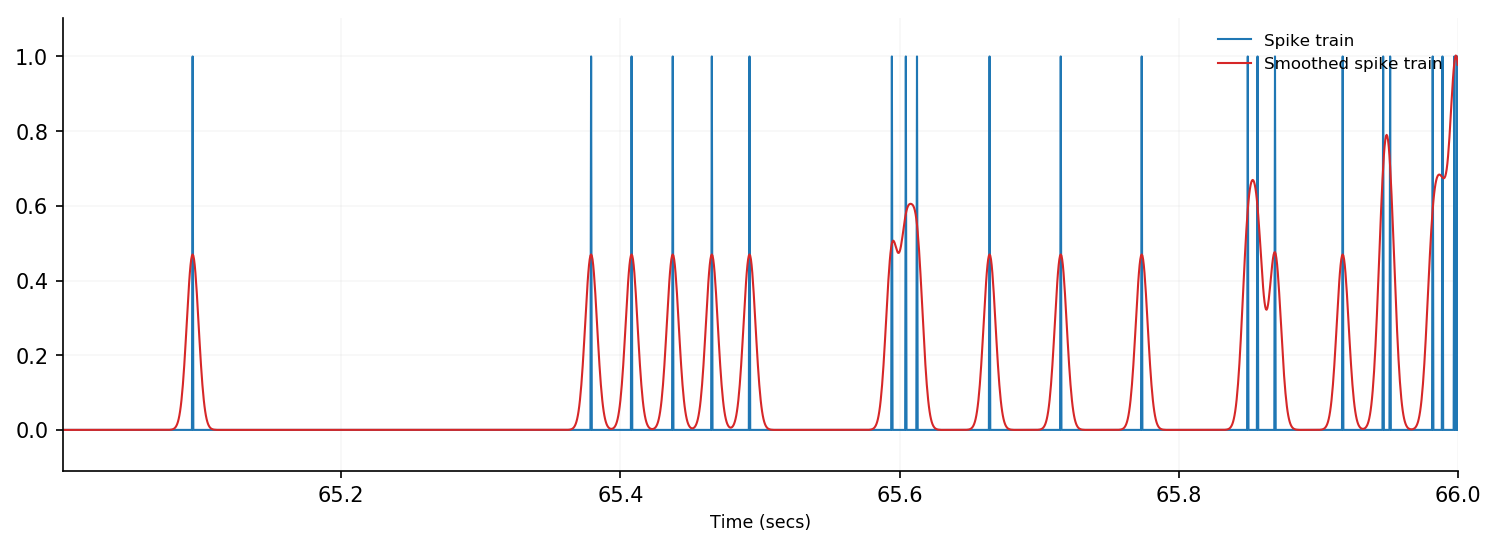

In [97]:
plot_trace(np.vstack((spike_train, 10*np.convolve(spike_train, g_win, mode='same'))), 
           start=65, duration=1, x_units='secs', linewidths=[1, 1], 
           legend_labels=['Spike train', 'Smoothed spike train'])

In [9]:
subj_sess = 'U369_env1'
sampling_rate = 2000
with open(os.path.join('/data3/scratch/dscho/frLfp/data/spikes', '{}_session_spikes.pkl'.format(subj_sess)), 'rb') as f:
    spikes = pickle.load(f)
fr_df, clus_to_chan, chan_to_clus = manning_analysis.get_fr_df(subj_sess, spikes)

spike_train = fr_df.at[0, 'spikes']
spike_times = np.where(spike_train>0)[0]
isi = sampling_rate / np.diff(spike_times) # instantaneous firing rate, in Hz

In [178]:
%%timeit
z1 = stats.zscore(spike_train1)
z2 = stats.zscore(spike_train2)
np.dot(z1, z2) / (np.linalg.norm(z1) * np.linalg.norm(z2))

63.1 ms ± 1.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [180]:
np.linalg.norm(z1), np.linalg.norm(z2)

(1592.5699356700388, 1592.5699356699663)

In [163]:
%timeit np.linalg.norm(z1)
%timeit np.sqrt(np.sum(z1**2))
np.

53.4 µs ± 2.93 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
5.42 ms ± 25.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [174]:
stats.pearsonr(spike_train1, spike_train2)

#np.dot(spike_train1 - np.mean(spike_train1), spike_train2 - np.mean(spike_train2)) / (np.sqrt(np.sum(spike_train1)) * np.sqrt(np.sum(spike_train2)))
#np.dot(spike_train1 - np.mean(spike_train1), spike_train2 - np.mean(spike_train2)) / (np.std(spike_train1) * np.std(spike_train2))

(0.0131565953475389, 1.7362413215454303e-97)

In [144]:
%timeit spike_train1 - np.mean(spike_train1)

4.66 ms ± 32.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [141]:
%timeit stats.pearsonr(spike_train1, spike_train2)
%timeit np.corrcoef(spike_train1, spike_train2)
%timeit np.dot(spike_train1, spike_train2)

46.9 ms ± 66.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
48.5 ms ± 108 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.09 µs ± 29.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [89]:
spike_train.shape

(2536279,)

In [96]:
np.sum(np.diff(spike_times)) / 2000 / 60
np.sum(spike_train) / (len(spike_train) / 2000)

1.4903723131406286

In [100]:
np.median(2000 / np.diff(spike_times))

3.5587188612099645

In [80]:
np.mean(np.convolve(isi, np.ones(50)/50, mode='same')), np.mean(isi)

(33.46962778793338, 33.533101749571244)

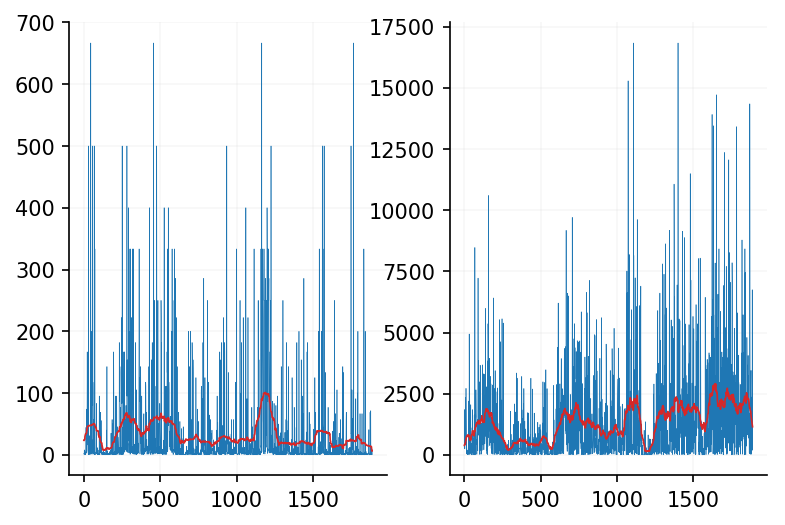

In [76]:
fig, ax = plt.subplots(1, 2)
ax = np.ravel(ax)

ax[0].plot(isi, linewidth=0.3)
ax[0].plot(np.convolve(isi, np.ones(100)/100, mode='same'))

ax[1].plot(np.diff(spike_times), linewidth=0.3)
ax[1].plot(np.convolve(np.diff(spike_times), np.ones(50)/50, mode='same'))

In [1459]:
start_time = time()
subj_sess = 'U369_env1'
spike_trains1 = epoch_spikes(subj_sess, fwhm=0, epoch_rate=200, save_outputs=False)
#spike_trains2 = TimeSeries.from_hdf(os.path.join(spikes_dir, '{}_spike_trains_100Hz-smooth_100Hz.hdf'.format(subj_sess)))
print('Done in {:.0f} secs'.format(time() - start_time))

Done in 33 secs


In [1488]:
%timeit stats.pearsonr(spike_trains1.data[0, :], spike_trains1.data[1, :])
%timeit np.dot(spike_trains1.data[0, :], spike_trains1.data[1, :])
%timeit np.diff(np.where(spike_trains1.data[0, :] > 0)[0])

1.94 ms ± 14.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
184 µs ± 519 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
175 µs ± 688 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [1474]:
isi = np.diff(np.where(spike_trains1.data[0, :] > 0)[0])

In [1483]:
#np.bincount(spike_trains1.data[0, :])
np.unique(spike_trains1.data[2, :], return_counts=True)

(array([0, 1, 2]), array([250153,   2847,     27]))

In [ ]:
# calculate instantaneous firing rate (np.diff(np.)) phase synchrony 

In [1438]:
def epoch_spikes(subj_sess, 
                 sampling_rate=2000, 
                 fwhm=100, 
                 epoch_rate=100, 
                 cut_time=1.5, 
                 save_outputs=True,
                 input_dir='/data3/scratch/dscho/frLfp/data/spikes',
                 output_dir='/scratch/dscho/unit_activity_and_hpc_theta/data/spikes'):
    """For each unit in the session, sum spikes into epochs of a specified duration.
    
    Parameters
    ----------
    subj_sess : str
        e.g. 'U367_env2'
    sampling_rate : int or float
        Sampling rate of the spike trains, in Hz.
    fwhm : int or float
        FWHM (in Hz) of the smoothing kernel that is applied to the spike
        train before epoching. If fwhm == 0 then no smoothing is done.
    epoch_rate : int or float
        Duration of each epoch, in Hz.
    cut_time : int or float
        Time in secs to cut from the start and end of the spike trains.
    save_outputs : bool
        If true, epoched spike trains for the session are saved as 
        a TimeSeries .hdf file.
    input_dir : str
        Directory where the input file is located. See
        manning_analysis.preprocess_session() for creation of the input file.
    output_dir : str
        Directory where the output file is saved.
       
    Returns
    -------
    spike_trains : ptsa.data.timeseries.TimeSeries
        Epoched spikes for each unit in the session. Dims are unit x time.
    """      
    # Load spikes.
    with open(os.path.join(input_dir, '{}_session_spikes.pkl'.format(subj_sess)), 'rb') as f:
        spikes = pickle.load(f)
    fr_df, clus_to_chan, chan_to_clus = manning_analysis.get_fr_df(subj_sess, spikes)
    
    # Convert cut_time from secs to epochs.
    cut = int(np.ceil((sampling_rate*cut_time) / (sampling_rate/epoch_rate)))
    
    # Get the smoothing kernel.
    if fwhm > 0:
        gwin = manning_utils.get_gwin(fwhm, sampling_rate)

    # Get time bins.
    n_timepoints = len(fr_df.at[0, 'spikes'])
    time_bins = manning_utils.get_epochs(np.arange(n_timepoints), epoch_size=(sampling_rate/epoch_rate), cut=cut)
    start_stop = (time_bins[0][0], time_bins[-1][1])
    
    spike_trains = []
    for unit in range(len(fr_df)):
        spike_train = fr_df.at[unit, 'spikes']
        
        # Smooth the spike train.
        if fwhm > 0:
            spike_train = np.convolve(spike_train, g_win, mode='same')
        
        # Sum the spikes within each epoch.
        spike_train, _ = manning_utils.epoch_vec(spike_train, 
                                                 func=np.sum,
                                                 start_stop=start_stop, 
                                                 n_bins=len(time_bins))
        spike_trains.append(spike_train)
    
    # Convert spike trains array into a TimeSeries object.
    spike_trains = np.array(spike_trains)
    spike_trains = TimeSeries(spike_trains, 
                              name=subj_sess, 
                              dims=['unit', 'time'],
                              coords={'unit': np.arange(spike_trains.shape[0]), 
                                      'time': np.arange(spike_trains.shape[1]),
                                      'samplerate': epoch_rate},
                              attrs={'channel': list(clus_to_chan.values()),
                                     'lfp_start_stop': start_stop,
                                     'fwhm_smooth': fwhm})
    
    if save_outputs:
        spike_trains_file = os.path.join(spikes_dir, '{}_spike_trains_{}Hz-smooth_{}Hz.hdf'.format(subj_sess, int(fwhm), int(epoch_rate)))
        spike_trains.to_hdf(spike_trains_file)
    
    return spike_trains

In [ ]:
# Apply a 30ms FWHM Gaussian smooth to spike trains from
# each session, cut the first and last 1.5 secs from the session,
# then sum spikes over 30ms epochs and save as a TimeSeries hdf5 file.
sampling_rate = 2000 # sampling rate, in Hz
fwhm = 1000/30 # FWHM of the smoothing kernel, in Hz
epoch_rate = 1000/30 # duration of each firing rate bin, in Hz
cut_time = 1.5 # time in secs to cut from start and end of the session
save_outputs = True

start_time = time()
for subj_sess in sorted(spike_chans.keys()):
    spike_trains = epoch_spikes(subj_sess,
                                sampling_rate=sampling_rate,
                                fwhm=fwhm,
                                epoch_rate=epoch_rate,
                                cut_time=cut_time,
                                save_outputs=save_outputs)
    
print('Done in {:.0f} secs'.format(time() - start_time))

In [255]:
# Apply a 10ms FWHM Gaussian smooth to spike trains from
# each session, cut the first and last 1.5 secs from the session,
# then sum spikes over 10ms bins and save.
sampling_rate = 2000
fwhm = 100 # FWHM of the smoothing kernel, in Hz
epoch_rate = 100 # duration of each firing rate bin, in Hz
cut_time = 1.5 # time in secs to cut from start and end of the session
save_outputs = True

start_time = time()
cut = int(np.ceil((sampling_rate*cut_time) / (sampling_rate/epoch_rate)))
gwin = manning_utils.get_gwin(fwhm, sampling_rate)
for subj_sess in sorted(spike_chans.keys()):
    # Load spikes.
    with open(os.path.join(data_dir, 'spikes', '{}_session_spikes.pkl'.format(subj_sess)), 'rb') as f:
        spikes = pickle.load(f)
    fr_df, clus_to_chan, chan_to_clus = manning_analysis.get_fr_df(subj_sess, spikes)
    
    # Get time bins.
    n_timepoints = len(fr_df.at[0, 'spikes'])
    time_bins = manning_utils.get_epochs(np.arange(n_timepoints), epoch_size=(sampling_rate/epoch_rate), cut=cut)
    start_stop = (time_bins[0][0], time_bins[-1][1])
    spike_trains = []
    for unit in range(len(fr_df)):
        spike_train = fr_df.at[unit, 'spikes']
        spike_train_smoothed = np.convolve(spike_train, g_win, mode='same')
        
        spike_train_smoothed_downsamp, _ = manning_utils.epoch_vec(spike_train_smoothed, 
                                                                   func=np.sum,
                                                                   start_stop=start_stop, 
                                                                   n_bins=len(time_bins))
        spike_trains.append(spike_train_smoothed_downsamp)
        
    spike_trains = np.array(spike_trains)
    spike_trains = TimeSeries(spike_trains, 
                              name=subj_sess, 
                              dims=['unit', 'time'],
                              coords={'unit': np.arange(spike_trains.shape[0]), 
                                      'time': np.arange(spike_trains.shape[1]),
                                      'samplerate': epoch_rate},
                              attrs={'channel': list(clus_to_chan.values()),
                                     'lfp_start_stop': start_stop,
                                     'fwhm_smooth': fwhm})
    if save_outputs:
        spike_trains_file = os.path.join(spikes_dir, '{}_spike_trains_{}Hz-smooth_{}Hz.hdf'.format(subj_sess, fwhm, epoch_rate))
        spike_trains.to_hdf(spike_trains_file)

print('Done in {:.0f} secs'.format(time() - start_time))

Done in 53 secs


In [950]:
# Get the dot product between each pair of units in unit_pairs_df. 
w = 20 # number of windows to slide back and forward in time
save_outputs = True

start_time = time()
# Get an array of temporal offsets to use in calculating cross-correlograms.
# Offsets are applied to the unit2 spike train while unit1 stays fixed,
# so negative offset is unit1 predicting past unit2 spikes, and positive
# offset is unit1 predicting future unit2 spikes.
offsets = np.arange(-w, w+1)
unit_ccgs = OrderedDict()
for subj_sess in sorted(unit_pairs_df.keys()):
    unit1s = unit_pairs_df[subj_sess].unit1.tolist()
    unit2s = unit_pairs_df[subj_sess].unit2.tolist()
    spikes = TimeSeries.from_hdf(os.path.join(spikes_dir, '{}_spike_trains_100Hz-smooth_100Hz.hdf'.format(subj_sess)))
    spikesdat = spikes.data
    n_timepoints = len(spikes.time)
    for unit1, unit2 in zip(unit1s, unit2s):
        unit_pair = '{}_{}'.format(unit1, unit2)
        vals = []
        for offset in offsets:
            vals.append(np.dot(spikesdat[unit1, w:n_timepoints-w], 
                               spikesdat[unit2, w+offset:n_timepoints-w+offset]))
        vals = np.array(vals)
        unit_ccgs.setdefault(subj_sess, OrderedDict())[unit_pair] = {'max': vals.max(),
                                                                     'max_offset': vals.argmax(),
                                                                     'mean': vals.mean(),
                                                                     'dot_products': vals}
    
if save_outputs:
    fname = os.path.join(spikes_dir, 'unit_ccgs.pkl')
    with open(fname, 'wb') as f:
        pickle.dump(unit_ccgs, f, pickle.HIGHEST_PROTOCOL)
    print('Saved unit_ccgs as {}'.format(fname))
    
print('Done in {:.0f} secs'.format(time() - start_time))

Saved unit_ccgs as /scratch/dscho/unit_activity_and_hpc_theta/data/spikes/unit_ccgs.pkl
Done in 36 secs


In [968]:
# BOOTSTRAP TESTING.
# Get the dot product between each pair of units in unit_pairs. 
w = 20 # number of windows to slide back and forward in time
n_bootstraps = 1000
alpha_low = 0.01
alpha_high = 0.05
save_outputs = True

start_time = time()
offsets = np.arange(-w, w+1)
thresh_low = int(n_bootstraps * (1-alpha_low))
thresh_high = int(n_bootstraps * (1-alpha_high))
unit_ccgs_rand = OrderedDict()
for subj_sess in sorted(unit_pairs_df.keys()):
    unit1s = unit_pairs_df[subj_sess].unit1.tolist()
    unit2s = unit_pairs_df[subj_sess].unit2.tolist()
    spikes = TimeSeries.from_hdf(os.path.join(spikes_dir, '{}_spike_trains_100Hz-smooth_100Hz.hdf'.format(subj_sess)))
    spikesdat = spikes.data
    n_timepoints = len(spikes.time)
    for unit1, unit2 in zip(unit1s, unit2s):
        unit_pair = '{}_{}'.format(unit1, unit2)
        vals = []
        for i in range(n_bootstraps):
            # Random sample with replacement: unit1 spike vector is shifted in time.
            unit1_time_shifted = np.roll(spikesdat[unit1, w:n_timepoints-w], 
                                         int(random.random()*(n_timepoints - 2*w)))
            vals_ = []
            for offset in offsets:
                vals_.append(np.dot(unit1_time_shifted, 
                                    spikesdat[unit2, w+offset:n_timepoints-w+offset]))
            vals.append(vals_)
        vals = np.array(vals) # bootstrap x offset
        
        # max_thresh is the cutoff threshold for the maximum dot product
        # from each bootstrap sample across all temporal offsets.
        vals_sorted_max = np.sort(vals.max(axis=1))
        max_thresh_low = vals_sorted_max[thresh_low]
        max_thresh_high = vals_sorted_max[thresh_high]
        
        # mean_thresh is the cutoff threshold for the mean dot product
        # from each bootstrap sample across all temporal offsets.
        vals_sorted_mean = np.sort(vals.mean(axis=1))
        mean_thresh_low = vals_sorted_mean[thresh_low]
        mean_thresh_high = vals_sorted_mean[thresh_high]
        
        unit_ccgs_rand.setdefault(subj_sess, OrderedDict())[unit_pair] = {'max_thresh_{}'.format(1-alpha_low): max_thresh_low,
                                                                          'max_thresh_{}'.format(1-alpha_high): max_thresh_high,
                                                                          'mean_thresh_{}'.format(1-alpha_low): mean_thresh_low,
                                                                          'mean_thresh_{}'.format(1-alpha_high): mean_thresh_high}

if save_outputs:
    fname = os.path.join(spikes_dir, 'unit_ccgs_rand.pkl')
    with open(fname, 'wb') as f:
        pickle.dump(unit_ccgs_rand, f, pickle.HIGHEST_PROTOCOL)
    print('Saved unit_ccgs_rand as {}'.format(fname))
    
print('Done in {:.0f} secs'.format(time() - start_time))

Done in 5 secs


In [1216]:
# Get the CCG DataFrame for all unit pairs analyzed.
alphas = [0.01, 0.05]
thresh_types = ['max', 'mean']
save_outputs = True

results = OrderedDict()
for subj_sess in sorted(unit_ccgs.keys()):
    df = unit_pairs_df[subj_sess].copy()
    unit_pairs = unit_pairs_df[subj_sess].unit_pair.tolist()
    for thresh_type in thresh_types:
        vals = []
        for unit_pair in unit_pairs:
            vals.append(unit_ccgs[subj_sess][unit_pair][thresh_type])
        df[thresh_type] = vals
    
    max_offsets = []
    ccgs = []
    norm_ccgs = []
    for unit_pair in unit_pairs:
        max_offset = unit_ccgs[subj_sess][unit_pair]['max_offset']
        ccg = unit_ccgs[subj_sess][unit_pair]['dot_products']
        if ccg.sum() == 0:
            norm_ccg = ccg
        else:
            norm_ccg = ccg / ccg.sum()
        max_offsets.append(max_offset)
        ccgs.append(ccg)
        norm_ccgs.append(norm_ccg)
    df['max_offset'] = max_offsets
    df['ccg'] = ccgs
    df['norm_ccg'] = norm_ccgs
    
    for thresh_type in thresh_types:
        for alpha in alphas:
            thresholds = []
            sigs = []
            for unit_pair in unit_pairs:
                val = unit_ccgs[subj_sess][unit_pair][thresh_type]
                thresh = unit_ccgs_rand[subj_sess][unit_pair]['{}_thresh_{}'.format(thresh_type, 1-alpha)]
                sig = val > thresh
                thresholds.append(thresh)
                sigs.append(sig)
            df['thresh_{}_{}'.format(thresh_type, str(int(alpha*100)).zfill(2))] = thresholds
            df['sig_{}_{}'.format(thresh_type, str(int(alpha*100)).zfill(2))] = sigs
    
    results[subj_sess] = df.copy()

ccg_df = pd.concat(results, ignore_index=True)
ccg_df.insert(8, 'roi1_nohemi', df.roi1.map(lambda x: x[1:]))
ccg_df.insert(9, 'roi2_nohemi', df.roi2.map(lambda x: x[1:]))

if save_outputs:
    fname = os.path.join(spikes_dir, 'ccg_df.pkl')
    with open(fname, 'wb') as f:
        pickle.dump(ccg_df, f, pickle.HIGHEST_PROTOCOL)
    print('Saved ccg_df as {}'.format(fname))

Saved ccg_df as /scratch/dscho/unit_activity_and_hpc_theta/data/spikes/ccg_df.pkl


## Analysis

In [1345]:
ccg_df.groupby('roi2_nohemi').roi2.count().sort_values(ascending=False)

roi2_nohemi
A       3199
EC      2513
OF      1699
AH      1638
PG      1422
AC      1202
TG       806
MC       532
TP       480
PH       435
ST       426
pSMA     391
MST      349
SMA      258
PS       150
MH       137
SAO       91
PC        78
PO        76
PST       66
one        9
IPO        9
Name: roi2, dtype: int64

In [1367]:
ccg_df.groupby(['subj_sess', 'roi2_nohemi']).roi2_nohemi.count()#.sort_values(ascending=False)

subj_sess  roi2_nohemi
U367_env2  A              312
           AH              89
           EC             104
           PH             224
           TG             806
U369_env1  A              154
           MH              21
           PS             105
           ST             126
U369_env2  A               30
           MH               2
           PS              45
           ST              39
U370_env1  A               28
           AH               1
           EC               8
           OF              22
U371_env1  A              306
           AH              29
           EC             270
           MH              25
           PG             234
           PH              89
U371_env2  A              285
           AH              63
           EC             133
           MH              16
           PG             209
           PH              83
U371_env3  A              364
                         ... 
U394_ses1  ST              80
U394_ses3  A     

In [1420]:
ccg_df.query("(both_hpc==False) & (roi2_nohemi!='A') & (sig_{}_{}==True)".format(thresh_type, alpha)).shape

(1355, 26)

In [1423]:
# Calculate the percent of significant pairs for a number of comparisons.
thresh_type = 'max'
alpha = '01'

col_names = ['pair_type', 'n_sig', 'n', 'pct_sig', 'max_offset', 'norm_ccgs']
brain_rois = ['A', 'EC', 'OF', 'PG', 'AC', 'TG', 'MC', 'TP', 'ST', 'pSMA', 'MST', 'SMA', 'PS']
sig_counts = []

# HPC-HPC: sig
pair_type = 'hpc_hpc'
n_sig = ccg_df.query("(both_hpc==True) & (sig_{}_{}==True)".format(thresh_type, alpha)).shape[0]
n = ccg_df.query("(both_hpc==True)".format(thresh_type, alpha)).shape[0]
pct_sig = n_sig / n
max_offset = ccg_df.query("(both_hpc==True) & (sig_{}_{}==True)".format(thresh_type, alpha)).max_offset.mean()
norm_ccgs = np.array(ccg_df.query("(both_hpc==True) & (sig_{}_{}==True)".format(thresh_type, alpha)).norm_ccg.tolist())
sig_counts.append([pair_type, n_sig, n, pct_sig, max_offset, norm_ccgs])

# HPC-Brain: sig
pair_type = 'hpc_brain'
n_sig = ccg_df.query("(both_hpc==False) & (sig_{}_{}==True)".format(thresh_type, alpha)).shape[0]
n = ccg_df.query("(both_hpc==False)".format(thresh_type, alpha)).shape[0]
pct_sig = n_sig / n
max_offset = ccg_df.query("(both_hpc==False) & (sig_{}_{}==True)".format(thresh_type, alpha)).max_offset.mean()
norm_ccgs = np.array(ccg_df.query("(both_hpc==False) & (sig_{}_{}==True)".format(thresh_type, alpha)).norm_ccg.tolist())
sig_counts.append([pair_type, n_sig, n, pct_sig, max_offset, norm_ccgs])

# HPC-Cortex: sig
pair_type = 'hpc_ctx'
n_sig = ccg_df.query("(both_hpc==False) & (roi2_nohemi!='A') & (sig_{}_{}==True)".format(thresh_type, alpha)).shape[0]
n = ccg_df.query("(both_hpc==False) & (roi2_nohemi!='A')".format(thresh_type, alpha)).shape[0]
pct_sig = n_sig / n
max_offset = ccg_df.query("(both_hpc==False) & (roi2_nohemi!='A') & (sig_{}_{}==True)".format(thresh_type, alpha)).max_offset.mean()
norm_ccgs = np.array(ccg_df.query("(both_hpc==False) & (roi2_nohemi!='A') & (sig_{}_{}==True)".format(thresh_type, alpha)).norm_ccg.tolist())
sig_counts.append([pair_type, n_sig, n, pct_sig, max_offset, norm_ccgs])

# HPC-Brain within-hem: sig
pair_type = 'hpc_brain_intrahem'
n_sig = ccg_df.query("(both_hpc==False) & (same_hemi==True) & (sig_{}_{}==True)".format(thresh_type, alpha)).shape[0]
n = ccg_df.query("(both_hpc==False) & (same_hemi==True)".format(thresh_type, alpha)).shape[0]
pct_sig = n_sig / n
max_offset = ccg_df.query("(both_hpc==False) & (same_hemi==True) & (sig_{}_{}==True)".format(thresh_type, alpha)).max_offset.mean()
norm_ccgs = np.array(ccg_df.query("(both_hpc==False) & (same_hemi==True) & (sig_{}_{}==True)".format(thresh_type, alpha)).norm_ccg.tolist())
sig_counts.append([pair_type, n_sig, n, pct_sig, max_offset, norm_ccgs])

# HPC-Brain between-hem: sig
pair_type = 'hpc_brain_interhem'
n_sig = ccg_df.query("(both_hpc==False) & (same_hemi==False) & (sig_{}_{}==True)".format(thresh_type, alpha)).shape[0]
n = ccg_df.query("(both_hpc==False) & (same_hemi==False)".format(thresh_type, alpha)).shape[0]
pct_sig = n_sig / n
max_offset = ccg_df.query("(both_hpc==False) & (same_hemi==False) & (sig_{}_{}==True)".format(thresh_type, alpha)).max_offset.mean()
norm_ccgs = np.array(ccg_df.query("(both_hpc==False) & (same_hemi==False) & (sig_{}_{}==True)".format(thresh_type, alpha)).norm_ccg.tolist())
sig_counts.append([pair_type, n_sig, n, pct_sig, max_offset, norm_ccgs])

# HPC-HPC within-bundle: sig
pair_type = 'hpc_hpc_intrabundle'
n_sig = ccg_df.query("(both_hpc==True) & (same_roi==True) & (sig_{}_{}==True)".format(thresh_type, alpha)).shape[0]
n = ccg_df.query("(both_hpc==True) & (same_roi==True)".format(thresh_type, alpha)).shape[0]
pct_sig = n_sig / n
max_offset = ccg_df.query("(both_hpc==True) & (same_roi==True) & (sig_{}_{}==True)".format(thresh_type, alpha)).max_offset.mean()
norm_ccgs = np.array(ccg_df.query("(both_hpc==True) & (same_roi==True) & (sig_{}_{}==True)".format(thresh_type, alpha)).norm_ccg.tolist())
sig_counts.append([pair_type, n_sig, n, pct_sig, max_offset, norm_ccgs])

# HPC-HPC between-bundle: sig
pair_type = 'hpc_hpc_interbundle'
n_sig = ccg_df.query("(both_hpc==True) & (same_roi==False) & (sig_{}_{}==True)".format(thresh_type, alpha)).shape[0]
n = ccg_df.query("(both_hpc==True) & (same_roi==False)".format(thresh_type, alpha)).shape[0]
pct_sig = n_sig / n
max_offset = ccg_df.query("(both_hpc==True) & (same_roi==False) & (sig_{}_{}==True)".format(thresh_type, alpha)).max_offset.mean()
norm_ccgs = np.array(ccg_df.query("(both_hpc==True) & (same_roi==False) & (sig_{}_{}==True)".format(thresh_type, alpha)).norm_ccg.tolist())
sig_counts.append([pair_type, n_sig, n, pct_sig, max_offset, norm_ccgs])

# Brain ROIs: sig
for roi in brain_rois:
    pair_type = 'hpc_{}'.format(roi)
    n_sig = ccg_df.query("(roi2_nohemi=='{}') & (sig_{}_{}==True)".format(roi, thresh_type, alpha)).shape[0]
    n = ccg_df.query("(roi2_nohemi=='{}')".format(roi, thresh_type, alpha)).shape[0]
    pct_sig = n_sig / n
    max_offset = ccg_df.query("(roi2_nohemi=='{}') & (sig_{}_{}==True)".format(roi, thresh_type, alpha)).max_offset.mean()
    norm_ccgs = np.array(ccg_df.query("(roi2_nohemi=='{}') & (sig_{}_{}==True)".format(roi, thresh_type, alpha)).norm_ccg.tolist())
    sig_counts.append([pair_type, n_sig, n, pct_sig, max_offset, norm_ccgs])
    
# A/M/P HPC-amygdala: sig
for roi in ['AH', 'MH', 'PH']:
    pair_type = '{}hpc_amygdala'.format(roi[0].lower())
    n_sig = ccg_df.query("(roi1_nohemi=='{}') & (roi2_nohemi=='A') & (sig_{}_{}==True)".format(roi, thresh_type, alpha)).shape[0]
    n = ccg_df.query("(roi1_nohemi=='{}') & (roi2_nohemi=='A')".format(roi, thresh_type, alpha)).shape[0]
    pct_sig = n_sig / n
    max_offset = ccg_df.query("(roi1_nohemi=='{}') & (roi2_nohemi=='A') & (sig_{}_{}==True)".format(roi, thresh_type, alpha)).max_offset.mean()
    norm_ccgs = np.array(ccg_df.query("(roi1_nohemi=='{}') & (roi2_nohemi=='A') & (sig_{}_{}==True)".format(roi, thresh_type, alpha)).norm_ccg.tolist())
    sig_counts.append([pair_type, n_sig, n, pct_sig, max_offset, norm_ccgs])
    
sig_counts_df = pd.DataFrame(sig_counts, columns=col_names)

In [1424]:
# max 01
sig_counts_df #.sort_values('pct_sig', ascending=False)

,pair_type,n_sig,n,pct_sig,max_offset,norm_ccgs
0,hpc_hpc,893,2210,0.404072,20.306831,"[[0.02890897037035048, 0.027985612971012507, 0..."
1,hpc_brain,2051,13756,0.149099,19.905900,"[[0.024393977698680396, 0.02413659068356872, 0..."
2,hpc_ctx,1355,10557,0.128351,19.910701,"[[0.024393977698680396, 0.02413659068356872, 0..."
3,hpc_brain_intrahem,1244,7131,0.174450,20.004019,"[[0.024393977698680396, 0.02413659068356872, 0..."
4,hpc_brain_interhem,807,6625,0.121811,19.754647,"[[0.024209362016727076, 0.02369947131133101, 0..."
5,hpc_hpc_intrabundle,662,1095,0.604566,20.172205,"[[0.026586274764843112, 0.021323688462559377, ..."
6,hpc_hpc_interbundle,231,1115,0.207175,20.692641,"[[0.02890897037035048, 0.027985612971012507, 0..."
7,hpc_A,696,3199,0.217568,19.896552,"[[0.016834457408383453, 0.02313421247505954, 0..."
8,hpc_EC,292,2513,0.116196,19.924658,"[[0.003670688654969569, 0.0029840751209570015,..."
9,hpc_OF,146,1699,0.085933,19.835616,"[[0.03054674985317192, 0.022939299021259872, 0..."


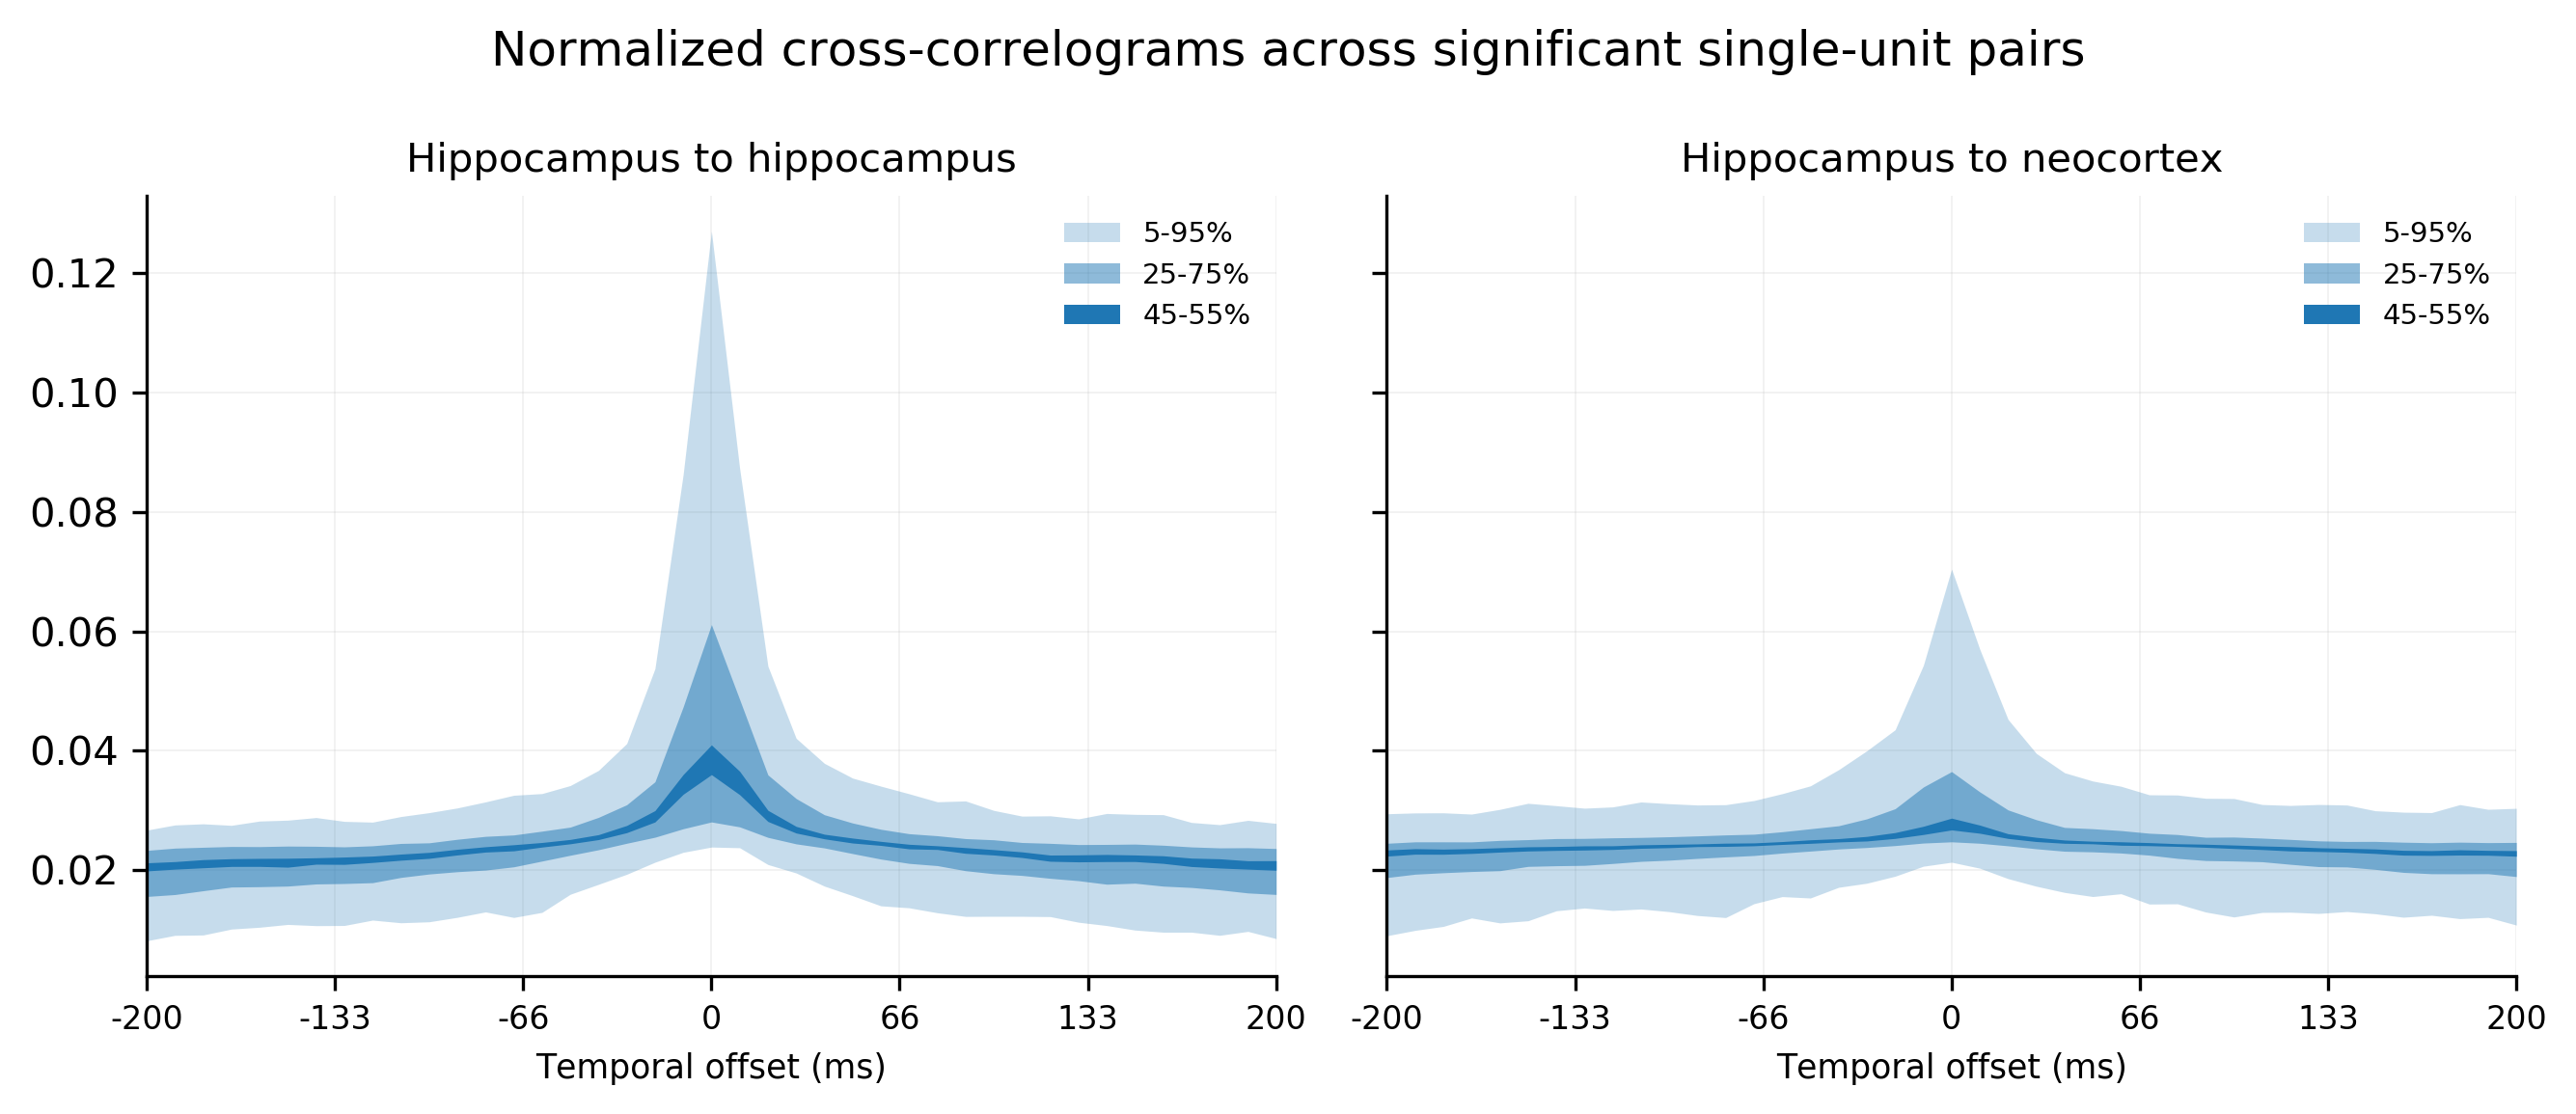

In [1434]:
xvals = np.arange(dat.shape[1])
xticks = np.linspace(0, len(offsets)-1, 7)
xticklabels = [int(x) for x in np.linspace(offsets[0]*10, offsets[-1]*10, 7)]

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(9, 4), dpi=300)
ax = np.ravel(ax)

dat = sig_counts_df.query("(pair_type=='hpc_hpc')").norm_ccgs.iat[0]

ax[0].fill_between(xvals, 
                   np.percentile(dat, 5, axis=0),
                   np.percentile(dat, 95, axis=0),
                   color='C0', alpha=0.25, linewidth=0, label='5-95%')
ax[0].fill_between(xvals, 
                   np.percentile(dat, 25, axis=0),
                   np.percentile(dat, 75, axis=0),
                   color='C0', alpha=0.5, linewidth=0, label='25-75%')
ax[0].fill_between(xvals, 
                   np.percentile(dat, 45, axis=0),
                   np.percentile(dat, 55, axis=0),
                   color='C0', alpha=1, linewidth=0, label='45-55%')
ax[0].set_title('Hippocampus to hippocampus')


dat = sig_counts_df.query("(pair_type=='hpc_ctx')").norm_ccgs.iat[0]

ax[1].fill_between(xvals, 
                   np.percentile(dat, 5, axis=0),
                   np.percentile(dat, 95, axis=0),
                   color='C0', alpha=0.25, linewidth=0, label='5-95%')
ax[1].fill_between(xvals, 
                   np.percentile(dat, 25, axis=0),
                   np.percentile(dat, 75, axis=0),
                   color='C0', alpha=0.5, linewidth=0, label='25-75%')
ax[1].fill_between(xvals, 
                   np.percentile(dat, 45, axis=0),
                   np.percentile(dat, 55, axis=0),
                   color='C0', alpha=1, linewidth=0, label='45-55%')
ax[1].set_title('Hippocampus to neocortex')

for i in range(2):
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels(xticklabels, fontsize=8)
    ax[i].set_xlim(xticks[0], xticks[-1])
    ax[i].set_xlabel('Temporal offset (ms)')
    ax[i].legend(loc=1, fontsize=7, bbox_to_anchor=[1, 1])
    
fig.suptitle('Normalized cross-correlograms across significant single-unit pairs', fontsize=12)
fig.tight_layout(rect=[0, 0.03, 1, 0.92])
# f = os.path.join(figure_dir, 'population_FR_mean-Z-unit-FR_{}_regions.png'.format(fr_bin_fr_all.shape[0]))
#fig.savefig(f)

In [ ]:
# For each each pair, get a list of offsets > the threshold for that pair.
# Across a grouping of pairs, get the percent of pairs at each offset position that show values > threshold.
# 

In [1272]:
thresh_type = 'max'
alpha = '01'
print(thresh_type, alpha)
print(ccg_df.query("(both_hpc==True) & (sig_{}_{} == False)".format(thresh_type, alpha)).shape)
print(ccg_df.query("(both_hpc==True) & (sig_{}_{} == True)".format(thresh_type, alpha)).shape)
print(ccg_df.query("(both_hpc==False) & (sig_{}_{} == False)".format(thresh_type, alpha)).shape)
print(ccg_df.query("(both_hpc==False) & (sig_{}_{} == True)".format(thresh_type, alpha)).shape)

max 01
(1317, 24)
(893, 24)
(11705, 24)
(2051, 24)


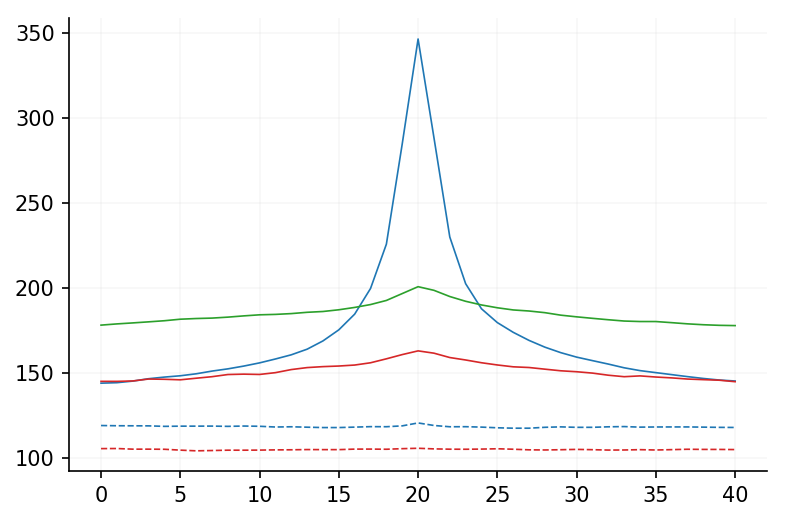

In [1317]:
thresh_type = 'max'
alpha = '01'

plt.plot(ccg_df.query("(both_hpc == True) & (same_roi == True) & (sig_{}_{} == False)".format(thresh_type, alpha))
         .ccg.mean(axis=0), color='C0', linestyle='--')
plt.plot(ccg_df.query("(both_hpc == True) & (same_roi == False) & (sig_{}_{} == False)".format(thresh_type, alpha))
         .ccg.mean(axis=0), color='C1', linestyle='--')

plt.plot(ccg_df.query("(both_hpc == True) & (same_roi == True) & (sig_{}_{} == True)".format(thresh_type, alpha))
         .ccg.mean(axis=0), color='C0')
plt.plot(ccg_df.query("(both_hpc == True) & (same_roi == False) & (sig_{}_{} == True)".format(thresh_type, alpha))
         .ccg.mean(axis=0), color='C1')
plt.plot(ccg_df.query("(both_hpc == False) & (sig_{}_{} == True)".format(thresh_type, alpha))
         .ccg.mean(axis=0), color='C2')

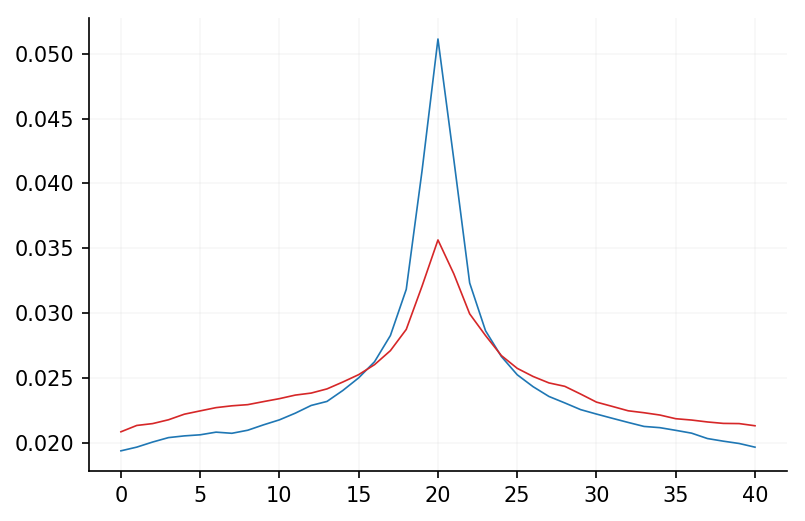

In [1310]:
thresh_type = 'max'
alpha = '01'
plt.plot(ccg_df.query("(both_hpc == True) & (sig_{}_{} == True)".format(thresh_type, alpha))
         .norm_ccg.mean(axis=0))
plt.plot(ccg_df.query("(both_hpc == False) & (sig_{}_{} == True)".format(thresh_type, alpha))
         .norm_ccg.mean(axis=0))

In [1221]:
ccg_df.columns

Index(['subj_sess', 'unit_pair', 'unit1', 'unit2', 'chan1', 'chan2', 'roi1',
       'roi2', 'same_roi', 'same_hemi', 'both_hpc', 'max', 'mean',
       'max_offset', 'ccg', 'norm_ccg', 'thresh_max_01', 'sig_max_01',
       'thresh_max_05', 'sig_max_05', 'thresh_mean_01', 'sig_mean_01',
       'thresh_mean_05', 'sig_mean_05'],
      dtype='object')

In [ ]:
# talk to Paul about region acronyms
# look percent sig connections between various combinations
# look at the 

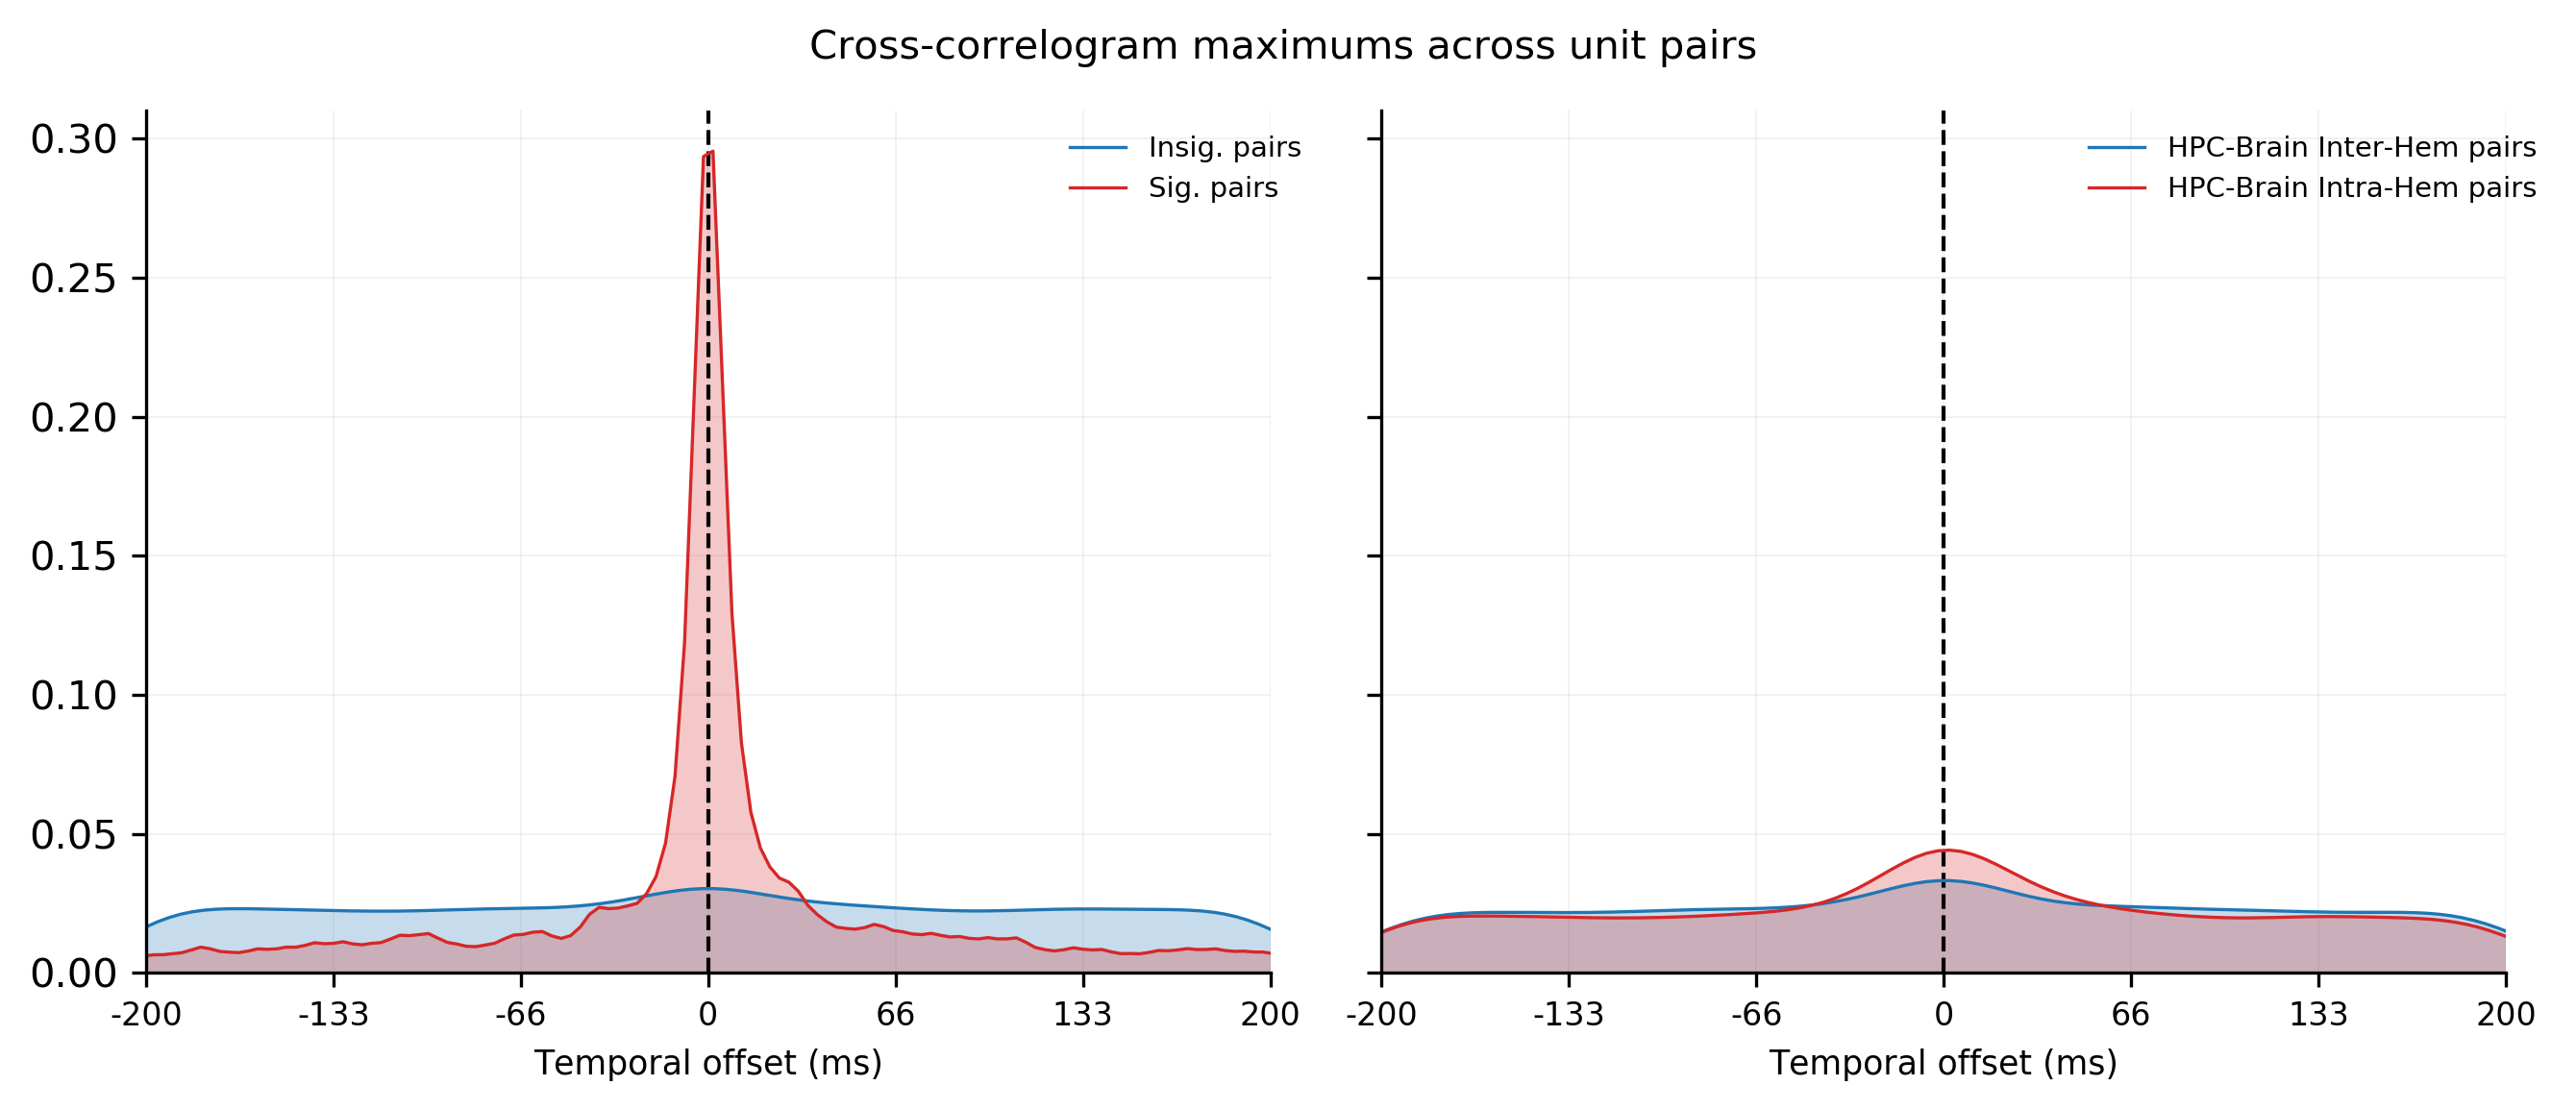

In [1284]:
thresh_type = 'max'
alpha = '01'

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(9, 4), dpi=300)
ax = np.ravel(ax)

xticks = np.linspace(0, len(offsets)-1, 7)
xticklabels = [int(x) for x in np.linspace(offsets[0]*10, offsets[-1]*10, 7)]

ax[0].axvline(x=20, color='k', alpha=1, linewidth=1, linestyle='--')
ax[0] = sns.kdeplot(np.array(ccg_df.query("(sig_{}_{} == False)"
                                          .format(thresh_type, alpha)).max_offset.tolist()), 
                    color='C0', shade=True, ax=ax[0], label='Insig. pairs')
ax[0] = sns.kdeplot(np.array(ccg_df.query("(sig_{}_{} == True)"
                                          .format(thresh_type, alpha)).max_offset.tolist()), 
                    color='C1', shade=True, ax=ax[0], label='Sig. pairs')

ax[1].axvline(x=20, color='k', alpha=1, linewidth=1, linestyle='--')
ax[1] = sns.kdeplot(np.array(ccg_df.query("(both_hpc==False) & (same_hemi==False)"
                                          .format(thresh_type, alpha)).max_offset.tolist()), 
                    color='C0', shade=True, ax=ax[1], label='HPC-Brain Inter-Hem pairs')
ax[1] = sns.kdeplot(np.array(ccg_df.query("(both_hpc==False) & (same_hemi==True)"
                                          .format(thresh_type, alpha)).max_offset.tolist()), 
                    color='C1', shade=True, ax=ax[1], label='HPC-Brain Intra-Hem pairs')

for i in range(2):
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels(xticklabels, fontsize=8)
    ax[i].set_xlim(xticks[0], xticks[-1])
    ax[i].set_xlabel('Temporal offset (ms)')
    ax[i].legend(loc=1, fontsize=7, bbox_to_anchor=[1.05, 1])

fig.suptitle('Cross-correlogram maximums across unit pairs')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

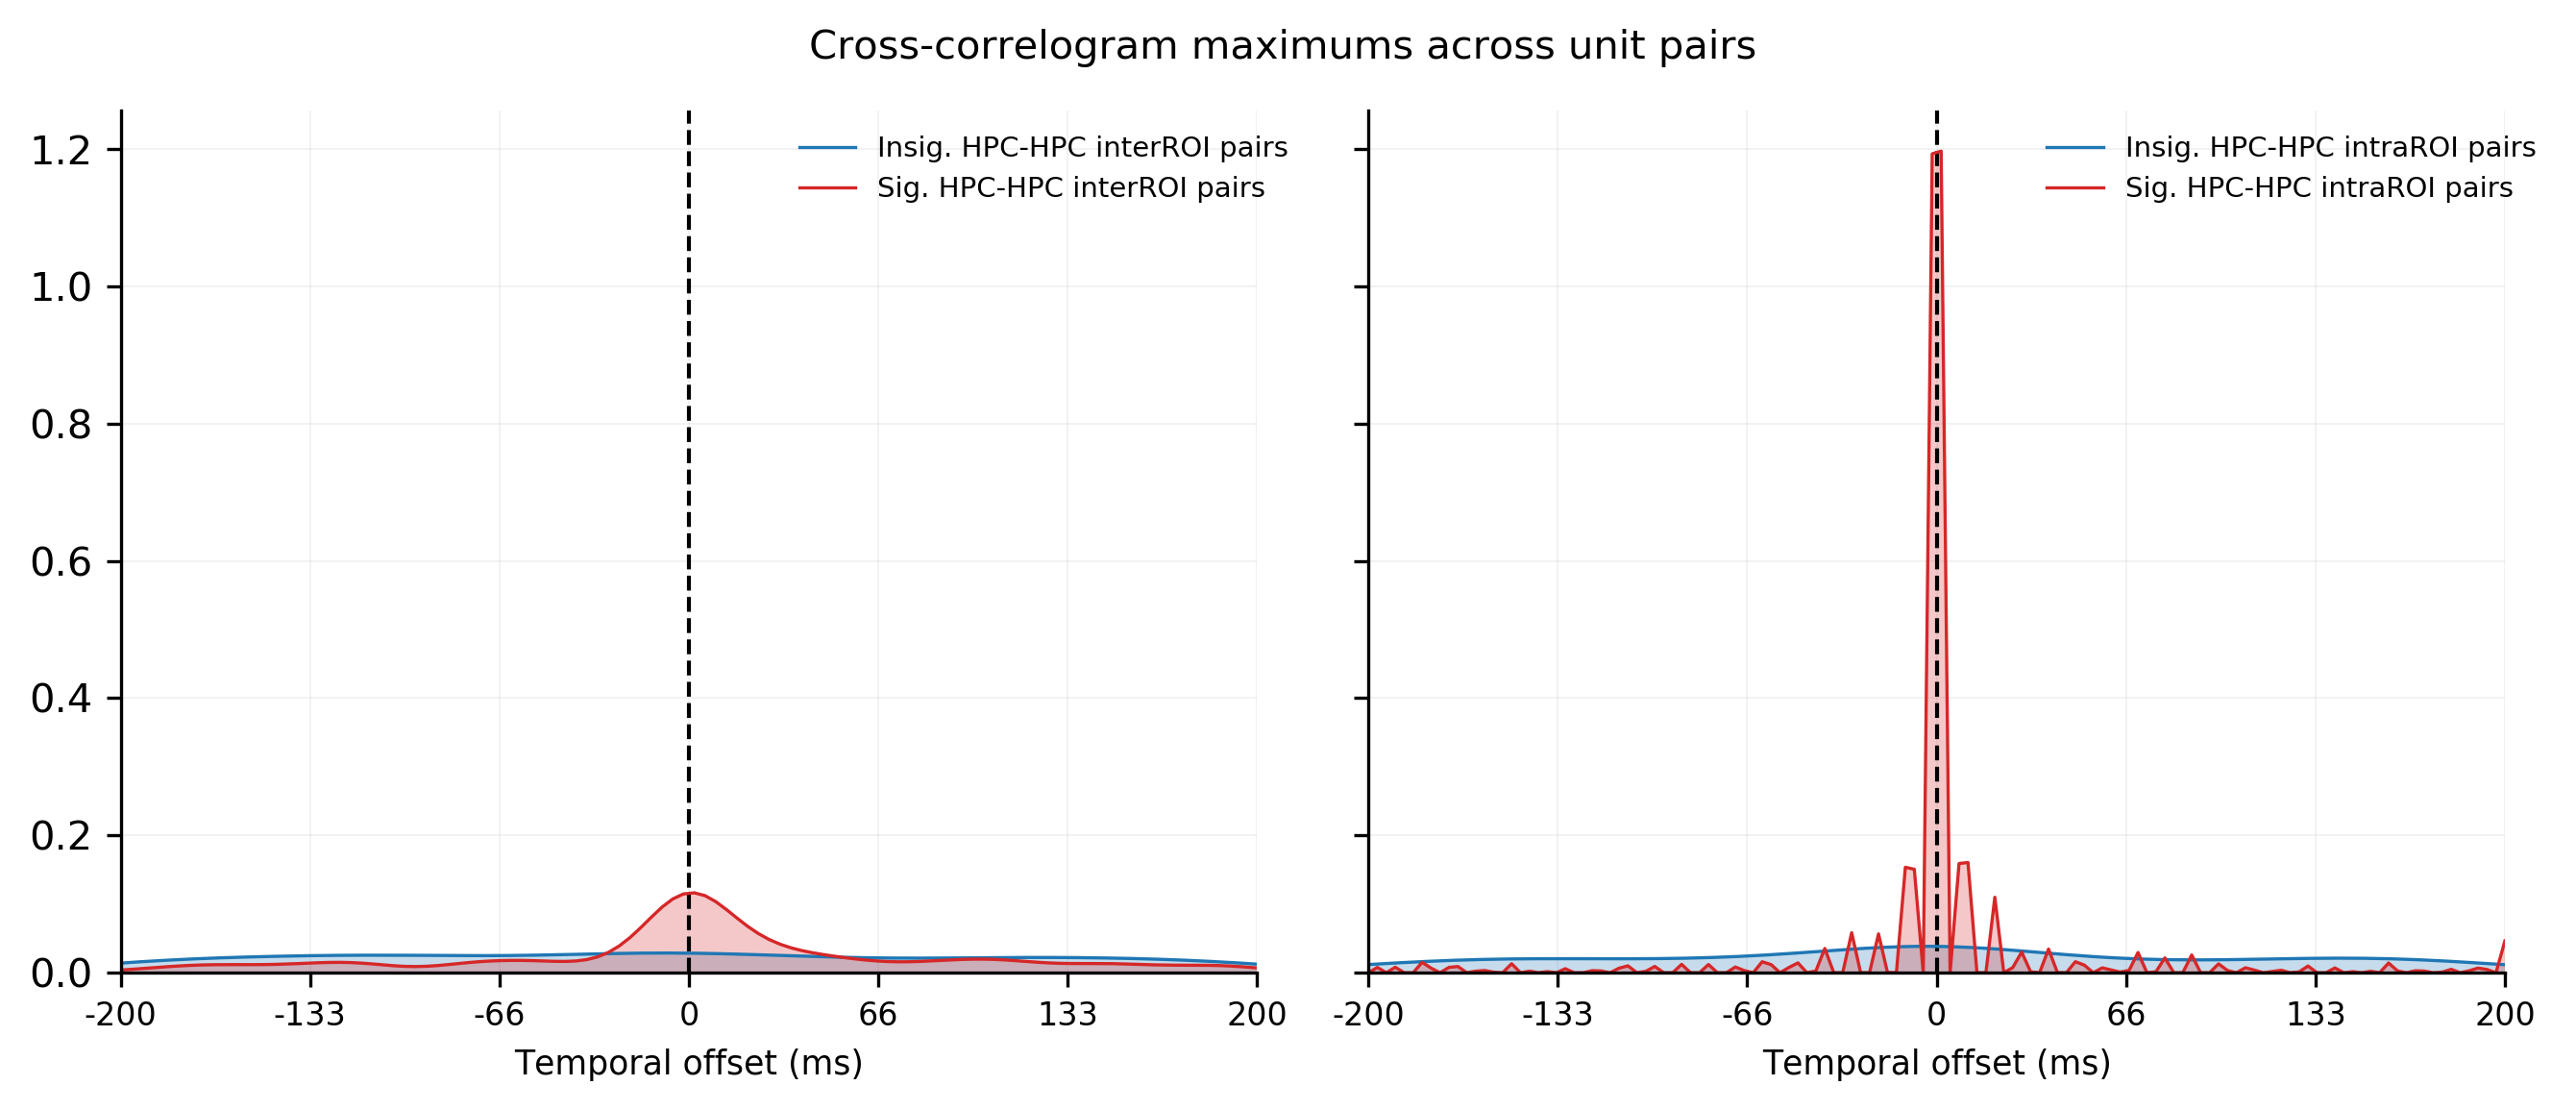

In [1280]:
thresh_type = 'max'
alpha = '01'

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(9, 4), dpi=300)
ax = np.ravel(ax)

xticks = np.linspace(0, len(offsets)-1, 7)
xticklabels = [int(x) for x in np.linspace(offsets[0]*10, offsets[-1]*10, 7)]


ax[0].axvline(x=20, color='k', alpha=1, linewidth=1, linestyle='--')
ax[0] = sns.kdeplot(np.array(ccg_df.query("(both_hpc==True) & (same_roi == False) & (sig_{}_{} == False)"
                                          .format(thresh_type, alpha)).max_offset.tolist()), 
                    color='C0', shade=True, ax=ax[0], label='Insig. HPC-HPC interROI pairs')
ax[0] = sns.kdeplot(np.array(ccg_df.query("(both_hpc==True) & (same_roi == False) & (sig_{}_{} == True)"
                                          .format(thresh_type, alpha)).max_offset.tolist()), 
                    color='C1', shade=True, ax=ax[0], label='Sig. HPC-HPC interROI pairs')

ax[1].axvline(x=20, color='k', alpha=1, linewidth=1, linestyle='--')
ax[1] = sns.kdeplot(np.array(ccg_df.query("(both_hpc==True) & (same_roi == True) & (sig_{}_{} == False)"
                                          .format(thresh_type, alpha)).max_offset.tolist()), 
                    color='C0', shade=True, ax=ax[1], label='Insig. HPC-HPC intraROI pairs')
ax[1] = sns.kdeplot(np.array(ccg_df.query("(both_hpc==True) & (same_roi == True) & (sig_{}_{} == True)"
                                          .format(thresh_type, alpha)).max_offset.tolist()), 
                    color='C1', shade=True, ax=ax[1], label='Sig. HPC-HPC intraROI pairs')

for i in range(2):
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels(xticklabels, fontsize=8)
    ax[i].set_xlim(xticks[0], xticks[-1])
    ax[i].set_xlabel('Temporal offset (ms)')
    ax[i].legend(loc=1, fontsize=7, bbox_to_anchor=[1.05, 1])

fig.suptitle('Cross-correlogram maximums across unit pairs')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

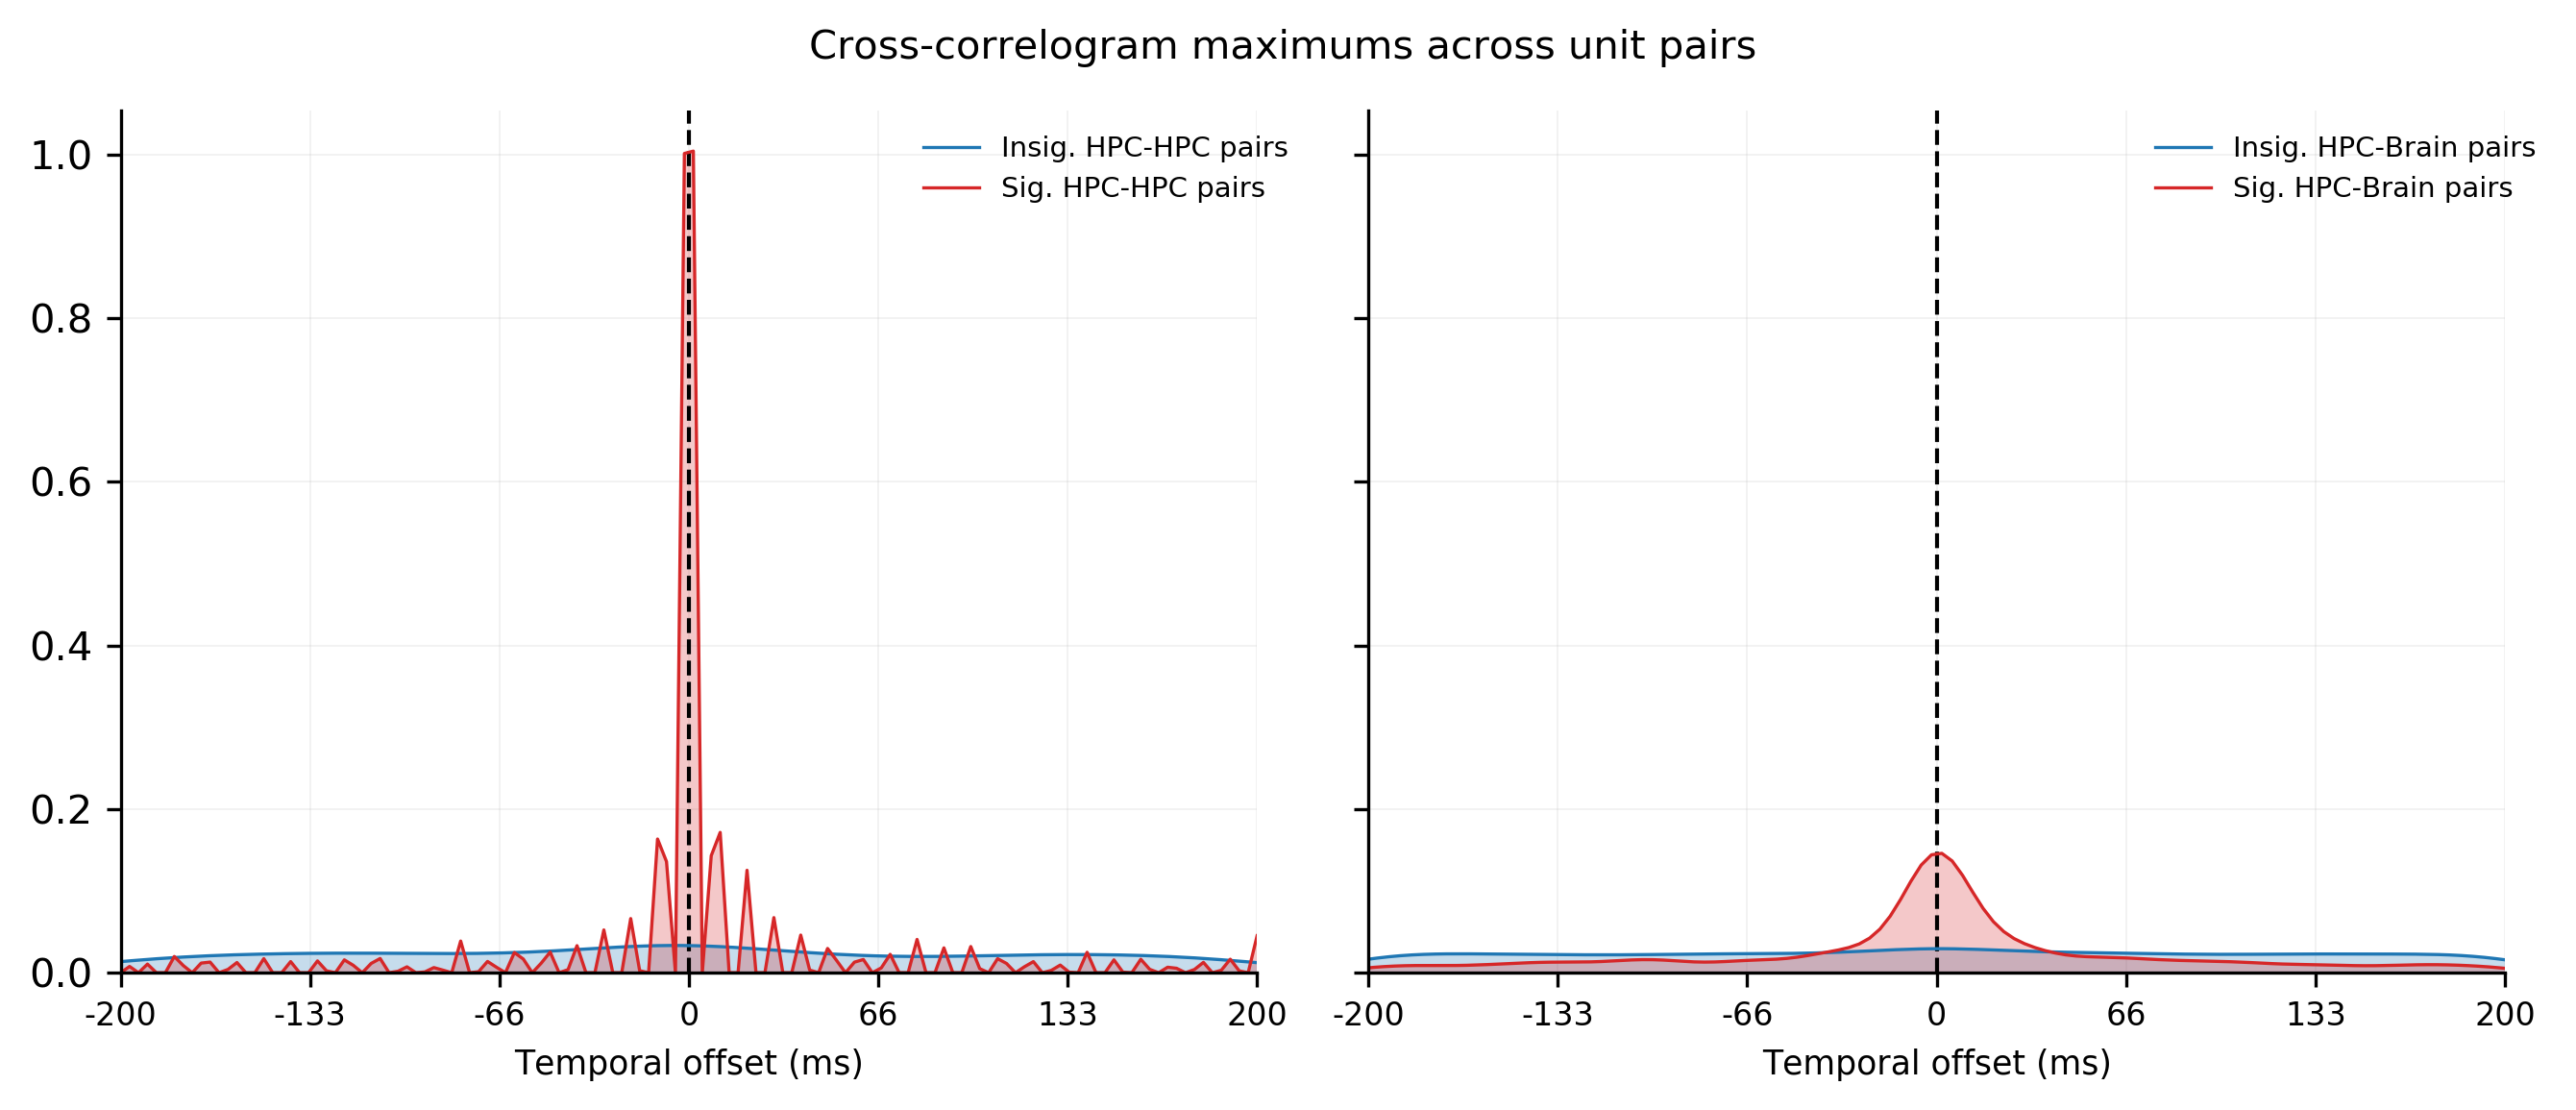

In [1276]:
thresh_type = 'max'
alpha = '01'

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(9, 4), dpi=300)
ax = np.ravel(ax)

xticks = np.linspace(0, len(offsets)-1, 7)
xticklabels = [int(x) for x in np.linspace(offsets[0]*10, offsets[-1]*10, 7)]

ax[0].axvline(x=20, color='k', alpha=1, linewidth=1, linestyle='--')
ax[0] = sns.kdeplot(np.array(ccg_df.query("(both_hpc==True) & (sig_{}_{} == False)".format(thresh_type, alpha)).max_offset.tolist()), 
                    color='C0', shade=True, ax=ax[0], label='Insig. HPC-HPC pairs')
ax[0] = sns.kdeplot(np.array(ccg_df.query("(both_hpc==True) & (sig_{}_{} == True)".format(thresh_type, alpha)).max_offset.tolist()), 
                    color='C1', shade=True, ax=ax[0], label='Sig. HPC-HPC pairs')

ax[1].axvline(x=20, color='k', alpha=1, linewidth=1, linestyle='--')
ax[1] = sns.kdeplot(np.array(ccg_df.query("(both_hpc==False) & (sig_{}_{} == False)".format(thresh_type, alpha)).max_offset.tolist()), 
                    color='C0', shade=True, ax=ax[1], label='Insig. HPC-Brain pairs')
ax[1] = sns.kdeplot(np.array(ccg_df.query("(both_hpc==False) & (sig_{}_{} == True)".format(thresh_type, alpha)).max_offset.tolist()), 
                    color='C1', shade=True, ax=ax[1], label='Sig. HPC-Brain pairs')

for i in range(2):
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels(xticklabels, fontsize=8)
    ax[i].set_xlim(xticks[0], xticks[-1])
    ax[i].set_xlabel('Temporal offset (ms)')
    ax[i].legend(loc=1, fontsize=7, bbox_to_anchor=[1.05, 1])

fig.suptitle('Cross-correlogram maximums across unit pairs')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## Graveyard

In [1271]:
##########
alpha = 0.01
thresh_type = 'max'

sig_count = 1

max_offsets = {'intra-hpc-sig': [], 'inter-hpc-sig': [],
               'intra-hpc-notsig': [], 'inter-hpc-notsig': [],
               'same-roi-sig': [], 'same-roi-notsig': []}
ccgs = {'intra-hpc-sig': [], 'inter-hpc-sig': [],
        'intra-hpc-notsig': [], 'inter-hpc-notsig': []}
ccgs_norm = {'intra-hpc-sig': [], 'inter-hpc-sig': [],
             'intra-hpc-notsig': [], 'inter-hpc-notsig': []}

for subj_sess in sorted(unit_ccgs.keys()):
#     both_hpc = unit_pairs_df[subj_sess].both_hpc.tolist()
#     same_roi = unit_pairs_df[subj_sess].same_roi.tolist()
    for i, unit_pair in enumerate(sorted(unit_ccgs[subj_sess].keys())):
        both_hpc = unit_pairs_df[subj_sess].query("(unit_pair=='{}')".format(unit_pair)).both_hpc.iat[0]
        same_roi = unit_pairs_df[subj_sess].query("(unit_pair=='{}')".format(unit_pair)).same_roi.iat[0]
        thresh = unit_ccgs_rand[subj_sess][unit_pair]['{}_thresh_{}'.format(thresh_type, 1-alpha)]
        max_offset = unit_ccgs[subj_sess][unit_pair]['max_offset']
        dot_prods = unit_ccgs[subj_sess][unit_pair]['dot_products']
        if dot_prods.sum() == 0:
            dot_prods_norm = dot_prods
        else:
            dot_prods_norm = dot_prods / dot_prods.sum() 
            
        if unit_ccgs[subj_sess][unit_pair][thresh_type] > thresh:
            sig_count += 1
            if both_hpc:
                max_offsets['intra-hpc-sig'].append(max_offset)
                ccgs['intra-hpc-sig'].append(dot_prods)
                ccgs_norm['intra-hpc-sig'].append(dot_prods_norm)
            else:
                max_offsets['inter-hpc-sig'].append(max_offset)
                ccgs['inter-hpc-sig'].append(dot_prods)
                ccgs_norm['inter-hpc-sig'].append(dot_prods_norm)
        else:
            if both_hpc:
                max_offsets['intra-hpc-notsig'].append(max_offset)
                ccgs['intra-hpc-notsig'].append(dot_prods)
                ccgs_norm['intra-hpc-notsig'].append(dot_prods_norm)
            else:
                max_offsets['inter-hpc-notsig'].append(max_offset)
                ccgs['inter-hpc-notsig'].append(dot_prods)
                ccgs_norm['inter-hpc-notsig'].append(dot_prods_norm)

for key in max_offsets.keys():
    max_offsets[key] = np.array(max_offsets[key]) 
for key in ccgs.keys():
    ccgs[key] = np.array(ccgs[key])
        
n_intra_hpc_sig = len(ccgs['intra-hpc-sig'])
n_intra_hpc = len(ccgs['intra-hpc-sig']) + len(ccgs['intra-hpc-notsig'])
n_inter_hpc_sig = len(ccgs['inter-hpc-sig'])
n_inter_hpc = len(ccgs['inter-hpc-sig']) + len(ccgs['inter-hpc-notsig'])

print('{} vals, alpha {}:\n\t{}/{} ({:.0f}%) intra-HPC pairs significant\n\t{}/{} ({:.0f}%) inter-HPC pairs significant'
      .format(thresh_type, alpha, 
              n_intra_hpc_sig, n_intra_hpc, 100 * n_intra_hpc_sig/n_intra_hpc,
              n_inter_hpc_sig, n_inter_hpc, 100 * n_inter_hpc_sig/n_inter_hpc))

max vals, alpha 0.01:
	893/2210 (40%) intra-HPC pairs significant
	2051/13756 (15%) inter-HPC pairs significant


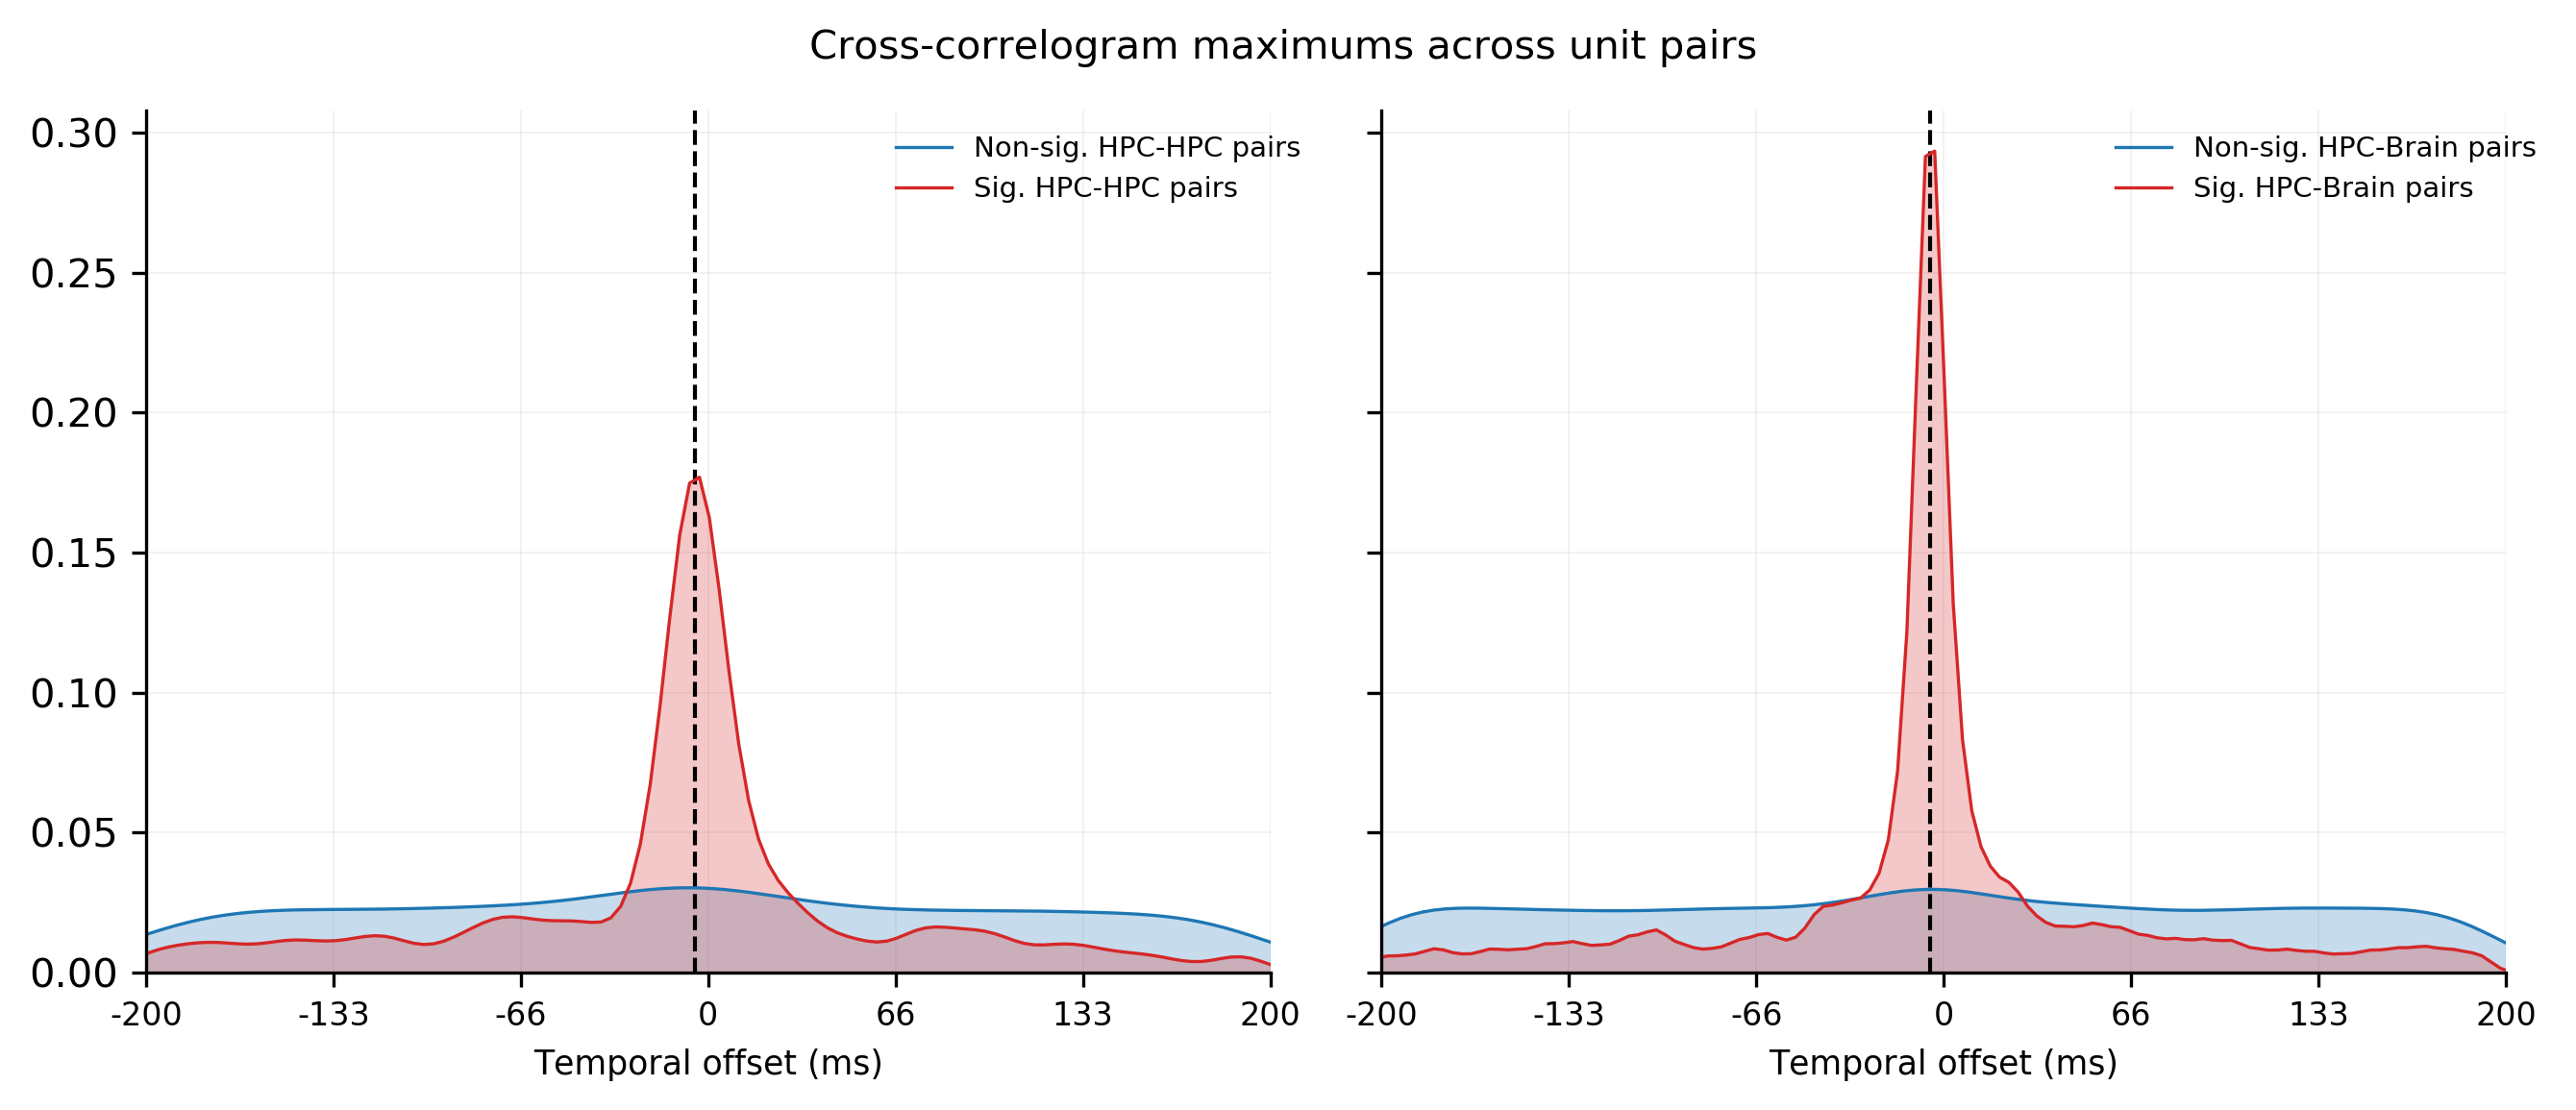

In [1053]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(9, 4), dpi=300)
ax = np.ravel(ax)

cats = ['intra-hpc-notsig', 'intra-hpc-sig',
        'inter-hpc-notsig', 'inter-hpc-sig']
fancy_cats = {'intra-hpc-sig': 'Sig. HPC-HPC pairs',
              'intra-hpc-notsig': 'Non-sig. HPC-HPC pairs',
              'inter-hpc-sig': 'Sig. HPC-Brain pairs',
              'inter-hpc-notsig': 'Non-sig. HPC-Brain pairs'}
xticks = np.linspace(0, len(offsets), 7)
xticklabels = [int(x) for x in np.linspace(offsets[0]*10, offsets[-1]*10, 7)]

ax[0].axvline(x=20, color='k', alpha=1, linewidth=1, linestyle='--')
ax[0] = sns.kdeplot(np.array(max_offsets[cats[0]]), color='C0', shade=True, ax=ax[0], label=fancy_cats[cats[0]])
ax[0] = sns.kdeplot(np.array(max_offsets[cats[1]]), color='C1', shade=True, ax=ax[0], label=fancy_cats[cats[1]])

ax[1].axvline(x=20, color='k', alpha=1, linewidth=1, linestyle='--')
ax[1] = sns.kdeplot(np.array(max_offsets[cats[2]]), color='C0', shade=True, ax=ax[1], label=fancy_cats[cats[2]])
ax[1] = sns.kdeplot(np.array(max_offsets[cats[3]]), color='C1', shade=True, ax=ax[1], label=fancy_cats[cats[3]])

for i in range(2):
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels(xticklabels, fontsize=8)
    ax[i].set_xlim(xticks[0], xticks[-1])
    ax[i].set_xlabel('Temporal offset (ms)')
    ax[i].legend(loc=1, fontsize=7, bbox_to_anchor=[1.05, 1])

fig.suptitle('Cross-correlogram maximums across unit pairs')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [951]:
max_offsets = {'intra-hpc': [], 'inter-hpc': [], 
               'intra-roi': [], 'inter-roi': [],
               'intra-hem': [], 'inter-hem': [], 
               'intra-hpc_intra-roi': [], 'intra-hpc_inter-roi': [],
               'intra-hpc_inter-roi_intra-hem': [], 'intra-hpc_inter-roi_inter-hem': [],
               'inter-hpc_intra-hem': [], 'inter-hpc_inter-hem': []}
for subj_sess in sorted(unit_ccgs.keys()):
    unit_pairs_ = unit_pairs[subj_sess]
    for ind in range(len(unit_pairs_)):
        unit1 = unit_pairs_.at[ind, 'unit1']
        unit2 = unit_pairs_.at[ind, 'unit2']
        unit_pair = '{}_{}'.format(unit1, unit2)
        same_roi = unit_pairs_.at[ind, 'same_roi']
        same_hemi = unit_pairs_.at[ind, 'same_hemi']
        both_hpc = unit_pairs_.at[ind, 'both_hpc']
        
        if same_roi:
            max_offsets['intra-roi'].append(unit_ccgs[subj_sess][unit_pair]['max_offset'])
        else:
            max_offsets['inter-roi'].append(unit_ccgs[subj_sess][unit_pair]['max_offset'])
            
        if same_hemi:
            max_offsets['intra-hem'].append(unit_ccgs[subj_sess][unit_pair]['max_offset'])
        else:
            max_offsets['inter-hem'].append(unit_ccgs[subj_sess][unit_pair]['max_offset'])
            
        if both_hpc:
            max_offsets['intra-hpc'].append(unit_ccgs[subj_sess][unit_pair]['max_offset'])
            if same_roi:
                max_offsets['intra-hpc_intra-roi'].append(unit_ccgs[subj_sess][unit_pair]['max_offset'])
            else:
                max_offsets['intra-hpc_inter-roi'].append(unit_ccgs[subj_sess][unit_pair]['max_offset'])
                if same_hemi:
                    max_offsets['intra-hpc_inter-roi_intra-hem'].append(unit_ccgs[subj_sess][unit_pair]['max_offset'])
                else:
                    max_offsets['intra-hpc_inter-roi_inter-hem'].append(unit_ccgs[subj_sess][unit_pair]['max_offset'])
        else:
            max_offsets['inter-hpc'].append(unit_ccgs[subj_sess][unit_pair]['max_offset'])
            if same_hemi:
                max_offsets['inter-hpc_intra-hem'].append(unit_ccgs[subj_sess][unit_pair]['max_offset'])
            else:
                max_offsets['inter-hpc_inter-hem'].append(unit_ccgs[subj_sess][unit_pair]['max_offset'])

for key in max_offsets.keys():
    max_offsets[key] = np.array(max_offsets[key])

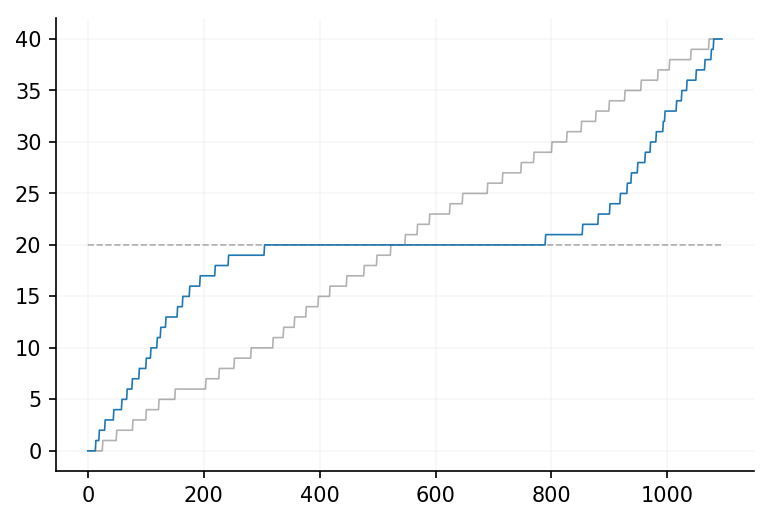

In [960]:
pair_types = ['inter-hpc_intra-hem', 'inter-hpc_inter-hem']
pair_types = ['intra-hpc_intra-roi']
plt.plot(np.repeat(20, len(max_offsets[pair_types[0]])), color='k', linestyle='--', alpha=0.3)
plt.plot(np.sort(np.random.randint(0, 41, len(max_offsets[pair_types[0]]))), color='k', alpha=0.3)
for pair_type in pair_types:
    plt.plot(np.sort(max_offsets[pair_type]))

In [731]:
# ~14 mins per session for rand testing
2 * len(unit_pairs[subj_sess]) / 60


13.533333333333333

In [685]:
# BOOTSTRAP TESTING.
# Get the dot product between each pair of units in unit_pairs. 

# Get an array of temporal offsets to use in calculating cross-correlograms.
# Offsets are applied to the unit1 spike train while unit2 stays fixed,
# so negative offset is unit 1 spikes predicting future unit2 spikes.
offsets = [int(i) for i in np.linspace(-50, 50, 101)]
n_bootstraps_max = 100 * len(offsets)
n_bootstraps_mean = 1000
alpha_max = 0.05
alpha_mean = 0.01
save_outputs = True

start_time = time()
max_thresh_ind = int(n_bootstraps_max*(1-alpha_max/len(offsets))) # Bonferroni correct for n_comparisons
mean_thresh_ind = int(n_bootstraps_mean*(1-alpha_mean))
unit_ccgs_rand = OrderedDict()
for subj_sess in sorted(unit_pairs.keys())[:1]:
    unit1s = unit_pairs[subj_sess].unit1.tolist()
    unit2s = unit_pairs[subj_sess].unit2.tolist()
    spikes = TimeSeries.from_hdf(os.path.join(spikes_dir, '{}_spike_trains_100Hz-smooth_100Hz.hdf'.format(subj_sess)))
    spikesdat = spikes.data
    n_timepoints = len(spikes.time)
    for unit1, unit2 in zip(unit1s, unit2s):
        unit_pair = '{}_{}'.format(unit1, unit2)
        
        vals = []
        for i in range(n_bootstraps_max):
            unit1_time_shifted = np.roll(spikesdat[unit1, 50:n_timepoints-50], 
                                         int(random.random()*(n_timepoints-100)))
            vals.append(np.dot(unit1_time_shifted, 
                               spikesdat[unit2, 50:n_timepoints-50]))
        
        mean_vals = []
        for i in range(n_bootstraps_mean):
            mean_vals.append(np.random.choice(vals, size=len(offsets), replace=False).mean())
        
        unit_ccgs_rand.setdefault(subj_sess, OrderedDict())[unit_pair] = {'max_thresh': np.sort(vals)[max_thresh_ind],
                                                                          'mean_thresh': np.sort(mean_vals)[mean_thresh_ind]}

if save_outputs:
    fname = os.path.join(spikes_dir, 'unit_ccgs_rand.pkl')
    with open(fname, 'wb') as f:
        pickle.dump(unit_ccgs_rand, f, pickle.HIGHEST_PROTOCOL)
    print('Saved unit_ccgs_rand as {}'.format(fname))
    
print('Done in {:.0f} secs'.format(time() - start_time))

KeyboardInterrupt: 

In [712]:
unit_ccgs[subj_sess][unit_pair]['dot_products'][50]

30.619470409686702

In [122]:
v1 = np.random.rand(400000)
v2 = np.random.rand(400000)
stats.pearsonr(v1, v2), np.dot(v1, v2)

%timeit stats.pearsonr(v1, v2)
%timeit np.dot(v1, v2)

2.36 ms ± 3.73 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
15.8 µs ± 455 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [15]:
# Get correlations between firing rate vectors for channels within a region
# versus for equal numbers of randomly paired channels within a session.
start = time()

fr_wroi_corrs = OrderedDict()
fr_broi_corrs = []

for subj_sess in sorted(spike_chans.keys()):
    subj_df_ = subj_df.loc[subj_df.subj_sess==subj_sess]
    loc_to_chan = OrderedDict(subj_df_.groupby('location', sort=False).chan.apply(list))
    
    # Load spikes.
    with open(os.path.join(data_dir, 'spikes', '{}_session_spikes.pkl'.format(subj_sess)), 'rb') as f:
        spikes = pickle.load(f)
    fr_df, clus_to_chan, chan_to_clus = manning_analysis.get_fr_df(subj_sess, spikes)
    n_timepoints = len(fr_df.fr.iat[0])
    sampling_rate = 2000.
#         spikes_ = pickle.load(f)
#     spikes = OrderedDict()
#     for key, value in spikes_.items():
#         spikes[str(key)] = value
#     spike_chans_ = list(spikes.keys())
    
    # Get all between-region channel pairs
    # for channels with 1+ units.
    loc_to_chan_mat = []
    for key, vals in loc_to_chan.items():
        if key != 'none':
            row_vals = [chan for chan in vals if chan in spike_chans_]
            if row_vals:
                loc_to_chan_mat.append(row_vals)
    broi_chan_pairs = []
    for xy in list(itertools.combinations(range(len(loc_to_chan_mat)), 2)):
        x, y = xy
        broi_chan_pairs += list(itertools.product(loc_to_chan_mat[x], loc_to_chan_mat[y]))
        
    rois = list(loc_to_chan.keys())
    for roi in rois:
        if roi == 'none':
            continue
        fr_roi = []
        chans = [chan for chan in loc_to_chan[roi] if chan in list(spikes.keys())]
        if len(chans) > 1:
            # Get firing rate correlations between all channels within a region.
            # Channel firing rate is the sum of the 1+ unit firing rates.
            for chan in chans:
                fr_roi.append(np.sum(spikes[chan]['fr'], axis=0))
            fr_roi = np.array(fr_roi)
            new_vals = np.corrcoef(fr_roi)[np.tril_indices(len(chans), k=-1)]
            if roi in fr_wroi_corrs:
                fr_wroi_corrs[roi] = np.append(fr_wroi_corrs[roi], new_vals)
            else:
                fr_wroi_corrs[roi] = new_vals
    
    # Get the correlation for each between-region channel pair.
    for broi_pair in broi_chan_pairs:
        chan1, chan2 = broi_pair
        fr_broi_corrs.append(stats.pearsonr(np.sum(spikes[chan1]['fr'], axis=0), np.sum(spikes[chan2]['fr'], axis=0))[0])
    
fr_broi_corrs = np.array(fr_broi_corrs)

fr_wroi_corrs_flat = []
for roi, vals in fr_wroi_corrs.items():
    fr_wroi_corrs_flat += list(vals)
fr_wroi_corrs_flat = np.array(fr_wroi_corrs_flat)

print('Done in {:.0f} secs'.format(time() - start))